# TODO
1. Check if ENV and device finally works
2. Get more data -- https://www.kaggle.com/datasets/ambityga/imagenet100
3. Refactor code and make it more readible
4. Look at Rotnet and check regression model
5. Make comparison with more complex models as feature extractors
6. Make sure that RGB channels corrsponds from preprocess ufnction to those in pytorch and write good show function (Blue images)
7. Find best batch_size and other hyperparams with W&B
8. Data augumentation 
9. Angel rotation has to be grater than 2 maybe or first class are not rotated and slightly because on captcha you can also slightly rotate stuff

## Extra
1. Check if loss and accuracy are corelated to different subject on image
2. Check if there are bottlenecks e.g during preprocessing images with cv2, it can be faster
3. Different sites nowadays also add little distortion to image, can be added

# Basic - How We want to solve this 

https://www.youtube.com/watch?v=c2pP8WFGtUg

Like here We rotate captcha every 1 degree of angle 
Make screen and put it into the network 
Than take an output when for example prediction of label not rotated will be over 98% (Precise treshold will be setted later)

So our final task is classification to get max prediction

0. Image not rotated
1. Image rotated

In [1]:
!nvidia-smi

Sun Sep  1 11:21:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   47C    P8             31W /  350W |    1180MiB /  24576MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [87]:
import cv2 as cv
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from numpy import arange
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, accuracy_score
import seaborn as sns

import time
import random
import os 
import imagesize
import pandas as pd 
from tqdm import tqdm

import gc
from concurrent.futures import ThreadPoolExecutor

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import list_models

from IPython.display import display

pd.options.display.max_colwidth = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed) # for multiple GPU

set_seed(69)

Using device: cuda


In [3]:
%%time
'''
Make a dataframe with paths to all imagenet images and labels  
'''
img_path = r'C:\ImageNet100'

def generate_df(img_path):
    filenames = [] # 38668 plikow
    for root, dirs, files in os.walk(img_path):
        for file in files:
            if file.endswith(".JPEG"):
                filenames.append(os.path.join(root, file))
                
    df = pd.DataFrame(filenames, columns=['filename'])
    print(len(filenames))
    return df

def check_image_size(filepath):
    w, h = imagesize.get(filepath)
    return filepath if h < 224 or w < 224 else None

def check_image_sizes(df):
    too_small_paths = []
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(check_image_size, df['filename']), total=len(df), desc="Checking image sizes"))
    too_small_paths = [r for r in results if r is not None]
    return too_small_paths

def remove_too_small_images(df, too_small_images):
    # Usuwanie wierszy, gdzie filename znajduje się na liście too_small_images
    df_cleaned = df[~df['filename'].isin(too_small_images)].reset_index(drop=True)
    return df_cleaned
    

df = generate_df(img_path)
df.columns = ['filename']

too_small_images = check_image_sizes(df)

df_cleaned = remove_too_small_images(df, too_small_images)

display(df_cleaned)

135000


Checking image sizes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135000/135000 [00:14<00:00, 9072.42it/s]


filename
0            C:\ImageNet100\train.X1\n01440764\n01440764_10026.JPEG
1            C:\ImageNet100\train.X1\n01440764\n01440764_10029.JPEG
2            C:\ImageNet100\train.X1\n01440764\n01440764_10040.JPEG
3            C:\ImageNet100\train.X1\n01440764\n01440764_10043.JPEG
4            C:\ImageNet100\train.X1\n01440764\n01440764_10048.JPEG
...                                                             ...
128735  C:\ImageNet100\val.X\n02077923\ILSVRC2012_val_00045435.JPEG
128736  C:\ImageNet100\val.X\n02077923\ILSVRC2012_val_00046758.JPEG
128737  C:\ImageNet100\val.X\n02077923\ILSVRC2012_val_00046767.JPEG
128738  C:\ImageNet100\val.X\n02077923\ILSVRC2012_val_00047983.JPEG
128739  C:\ImageNet100\val.X\n02077923\ILSVRC2012_val_00048240.JPEG

[128740 rows x 1 columns]

CPU times: total: 1min 4s
Wall time: 21.6 s


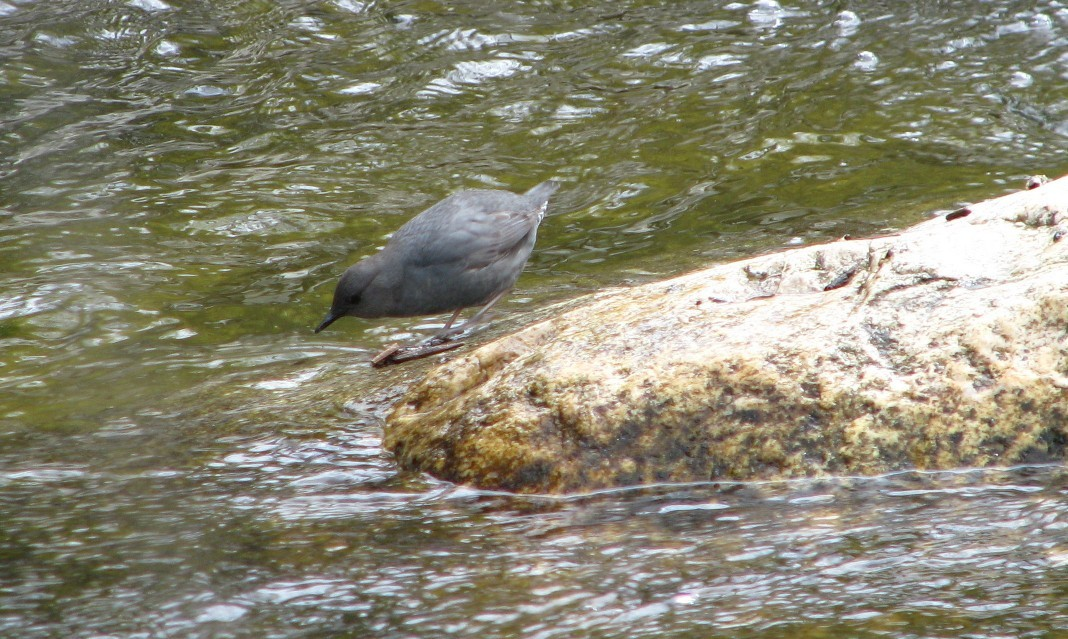

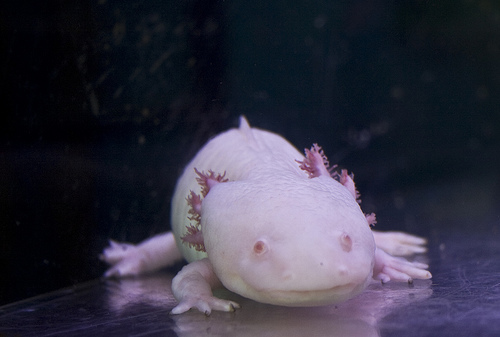

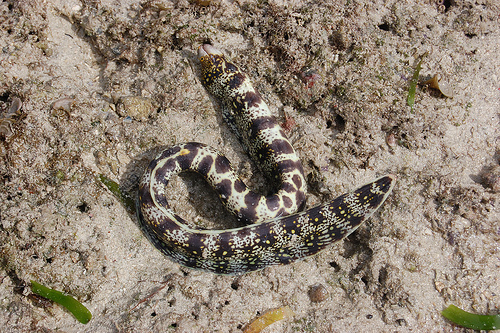

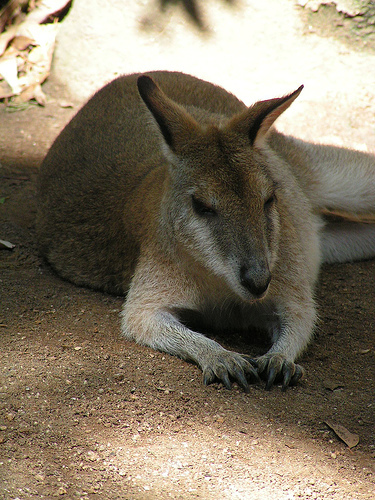

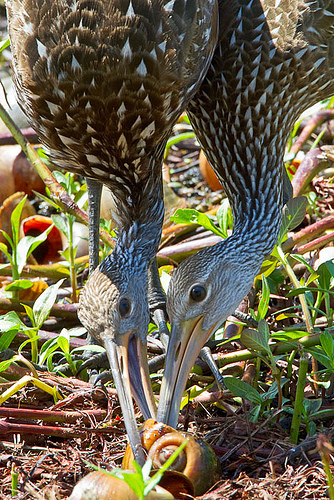

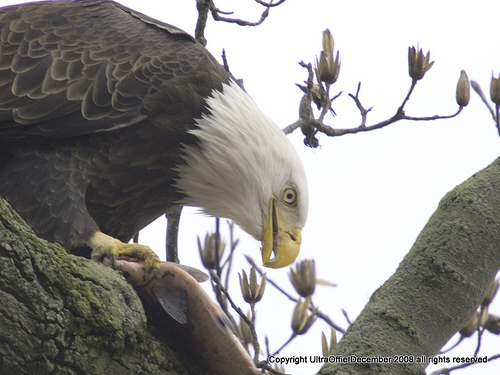

In [4]:
def show_random_images(df, num_images=6):
    sample_images = df.sample(num_images)['filename'].tolist()
    for img_path in sample_images:
        img = Image.open(img_path)
        display(img)

show_random_images(df_cleaned)

In [5]:
class ProcessImage():
    def __init__(self):
        return

    def rotate_pil(self, label, img_pth="rotnet.jpg", save=False, show=False):
        '''
        Function which load image and rotate it by random angle and cut
        then converts to cv2 format (np.array)

        --------------------------
        RETURNS:
            rectangular_cv :  numpy array - preprocessed image 224x224
            rotated_circle : np.array - rotated center
            angle : int - how much image was rotated
        '''
        img = Image.open(img_pth).convert('RGB')
        angle_start = random.randint(1, 359)
        rotate_img= img.rotate(angle_start)

        width, height = rotate_img.size   # Get dimensions

        new_width = 224
        new_height = 224

        left = (width - new_width)/2
        top = (height - new_height)/2
        right = (width + new_width)/2
        bottom = (height + new_height)/2

        # Crop 224 x 224
        rectangular_image = rotate_img.crop((left, top, right, bottom))

        # Rotate center
        new_img = rectangular_image.copy()
        w=130
        h=130
        center = new_img.size
        x = center[1]/2 - w/2
        y = center[0]/2 - h/2

        center_img = new_img.crop((int(x), int(y), int(x+w), int(y+h)))

        if label > 0:
            angle = label
            rotate_img = center_img.rotate(angle)
        elif label == 0:
            rotate_img = center_img
            angle = 0

        # back to cv2
        rectangular_cv = np.array(rectangular_image)
        # Convert RGB to BGR
        rectangular_cv = rectangular_cv[:, :, ::-1].copy()
        
        rotated_circle_cv = np.array(rotate_img)
        rotated_circle_cv = rotated_circle_cv[:, :, ::-1].copy()

        return rectangular_cv, rotated_circle_cv, angle

    def paste_rotated(self, base_image, rotated_circle, mask):
        '''
        Function which paste rotated circle inside
        '''
        w=130
        h=130
        center = base_image.shape
        x = center[1]/2 - w/2
        y = center[0]/2 - h/2
        crop_img = base_image[int(y):int(y+h), int(x):int(x+w)]
        mask_inv = cv.bitwise_not(mask) # MASKA DLA CROP_IMG

        # background
        img1_bg = cv.bitwise_and(crop_img,crop_img,mask = mask_inv)
        # foreground
        img2_fg = cv.bitwise_and(rotated_circle,rotated_circle,mask = mask)
        dst = cv.add(img1_bg,img2_fg)

        base_image[int(y):int(y+h), int(x):int(x+w)] = dst
        return base_image

    def add_white_circle(self, image, save=False):
        '''
        Adds white background
        '''
        white = (255, 255, 255)
        image = cv.circle(image, (112,112), 66, white, 2, lineType=cv.LINE_AA)
        image = cv.circle(image, (112,112), 160, white, 103, lineType=cv.LINE_AA)
        if save is True:
            cv.imwrite("img_masked_white.jpg", image)
        return image

    def _make_image(self, img_path, mask, label):
        '''
        ------------------------
        Returns:
            Image : torch.Tensor
            Label : int - Angle 0-180 
        '''
        rectangular_cv, rotated_circle_cv, angle = self.rotate_pil(label, img_path)
        rotated_image = self.paste_rotated(rectangular_cv, rotated_circle_cv, mask)
        final_image = self.add_white_circle(rotated_image)
        final_image = cv.cvtColor(final_image, cv.COLOR_BGR2RGB)
        return final_image, angle

def make_center_mask():
    mask = np.zeros((130, 130), dtype="uint8")
    return cv.circle(mask, (65, 65), 63, (255, 255, 255), -1, lineType=cv.LINE_AA)

def show_cv2_image(img_array):
    img_pil = Image.fromarray(img_array)
    display(img_pil)

Execution time: 0.0190 seconds


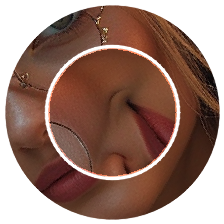

CPU times: total: 31.2 ms
Wall time: 25 ms


In [154]:
%%time

instance = ProcessImage() 
mask = make_center_mask()  

start_time = time.time()
final_image, angle = instance._make_image("ComfyUI_00102_.png", mask, 90) # color BGR
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")
show_cv2_image(final_image)


### Augumentation - do if needed (but there is a lot of train data)

1. Rotating in random positions
2. Change britghtenss contrast and random noise
3. Distortion in image as in new captchas

In [45]:
class RotnetBinaryDataGenerator(Dataset):
    """
    Dataset class for binary rotation classification:
    0: Not Rotated
    1: Rotated by a random angle
    """
    def __init__(self, df_cleaned):
        self.df = df_cleaned
        self.mask = self.make_center_mask()
        self.preprocess_engine = ProcessImage()
        self.transform = transforms.ToTensor()

    @staticmethod
    def make_center_mask():
        black_bg = np.zeros((130, 130), dtype="uint8")
        mask = cv.circle(black_bg, (65, 65), 63, (255, 255, 255), -1, lineType=cv.LINE_AA)
        return mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Returns a tuple of (image tensor, label).
        The label is 0 if the image is not rotated, and 1 if it is rotated.
        """
        image_path = self.df.loc[idx, 'filename']
        label = random.randint(0, 1)
        
        if label == 0:
            image, angle = self.preprocess_engine._make_image(image_path, self.mask, label)
        elif label == 1:
            angle = random.randint(1, 359)
            image, angle = self.preprocess_engine._make_image(image_path, self.mask, angle)

        tensor = self.transform(image)
        return tensor, label

In [46]:
dataset = RotnetBinaryDataGenerator(df_cleaned)

1


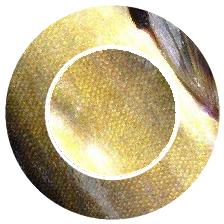

In [47]:
sample = dataset[32]
image_tensor, label = sample
print(sample[1])
# Konwersja tensora PyTorch na obraz PIL
to_pil = transforms.ToPILImage()
image = to_pil(image_tensor)

# Wyświetlenie obrazu
display(image)


### Models to test

1. EfficientNet: Faster and better Resnet, always worked
2. Swin Transformer: To test something more complex

Use it pretrained as feature extractor and add only classification head

(RELU) 512 -> 128 -> 2 (softmax/sigomid)*

We can use on end 
* 2 neurons output with softmax 
* 1 neuron with sigomid 

In this case I will use sigmoid approach - task closer to anomally detection?

In [12]:
all_models = list_models()
all_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [13]:
# Get EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, latent_dim=128):
        super(EfficientNet, self).__init__()
        self.feature_extractor = self._get_efficientnet(latent_dim=latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
            #nn.Linear(64, 1)#,  # 1 Neuron
            #nn.Sigmoid()  # To get probabilities - implifies using Binary Cross-Entropy (BCE): torch.nn.BCELoss()
        )

        # Can be simplified in future if overfitting will occure

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)  # DELETE IF SIGMOID
        return x

    def _get_efficientnet(self, latent_dim):
        model = models.efficientnet_b3(weights='EfficientNet_B3_Weights.DEFAULT')
        for param in model.parameters():
            param.requires_grad = False  # Zamrażanie wcześniejszych warstw modelu

        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, latent_dim),
            nn.ReLU(),  # Funkcja aktywacji
        )
        return model

# Przykład użycia
#embed_model = EfficientNet(latent_dim=512)
#x = torch.randn(1, 3, 224, 224)
#output = embed_model(x)
#print(output.shape)
#print('Model Structure:')
#print(embed_model)

In [14]:

class EmbeddingNet(nn.Module):
    def __init__(self, latent_dim=128, architecture=18):
        super(EmbeddingNet, self).__init__()
        self.architecture = architecture
        self.feature_extractor = self._getResnet(latent_dim=latent_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    def _getResnet(self,latent_dim):
        '''
        Sprawdzic czy daje tez FC
        '''
        if self.architecture == 18:
            model = models.resnet18(pretrained=True)
        elif self.architecture == 34:
            model = models.resnet34(pretrained=True)
        elif self.architecture == 50:
            model = models.resnet50(pretrained=True)
        elif self.architecture == 101:
            model = models.resnet101(pretrained=True)
        elif self.architecture == 152:
            model = models.resnet152(pretrained=True)
        else: print("MODEL NOT LOADED")
        
        for param in model.parameters():
            param.requires_grad= False # freeze beggining layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, latent_dim)
    


        return model

    def get_embedding(self, x):
        return self.forward(x)

class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes, latent_dim):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(latent_dim, n_classes) # 

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

#embed_model = EmbeddingNet(latent_dim=512, architecture=18)
#x = torch.randn(1, 3, 224, 224)
#output = embed_model(x)
#print(output.shape)

In [15]:
# Get Swin Transformers
class SwinV2T(nn.Module):
    def __init__(self, latent_dim=128):
        super(SwinV2T, self).__init__()
        self.feature_extractor = self._get_swin_v2_t(latent_dim=latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),  
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(256, 128),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)#,  
            #nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

    def _get_swin_v2_t(self, latent_dim):
        model = models.swin_v2_t(weights='DEFAULT')
        for param in model.parameters():
            param.requires_grad = False  

        num_features = model.head.in_features
        model.head = nn.Sequential(
            nn.Linear(num_features, latent_dim),
            nn.ReLU(),  
        )
        return model

# Przykład użycia
#model = SwinV2T(latent_dim=512)
#x = torch.randn(1, 3, 224, 224)
#output = model(x)
#print(output.shape)
#print('Model Structure:')
#print(model)

### Loss function - binary classification

Binary Cross-Entropy (BCE):
torch.nn.BCELoss() or torch.nn.BCEWithLogitsLoss() (If you dont want to use sigmoid in exit layer).


---- For version 3 -----

Focal Loss:
If data is unbalanced e.g. more sample in one class, it helps to train on harder examples

sigmoid_focal_loss in Pythorch needs to fine tune alpha and gamma

## Analyze dataloader

In [17]:
# Random split of 80:20 between training and validation
num_items = len(dataset)

num_train = round(num_items * 0.7)
num_val = round(num_items * 0.15)
num_test = num_items - num_train - num_val

train_ds, val_ds, test_ds = random_split(dataset, [num_train, num_val, num_test])

epoch = 15
learning_rate = 0.001
BATCH_SIZE = 128 # Check which is max


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f'Train images num: {num_train}')
print(f'Validation images num: {num_val}') # To fine tune hyper params
print(f'Test images num: {num_test}')



Train images num: 90118
Validation images num: 19311
Test images num: 19311


Example data shape: torch.Size([128, 3, 224, 224])
Example labels: tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0])


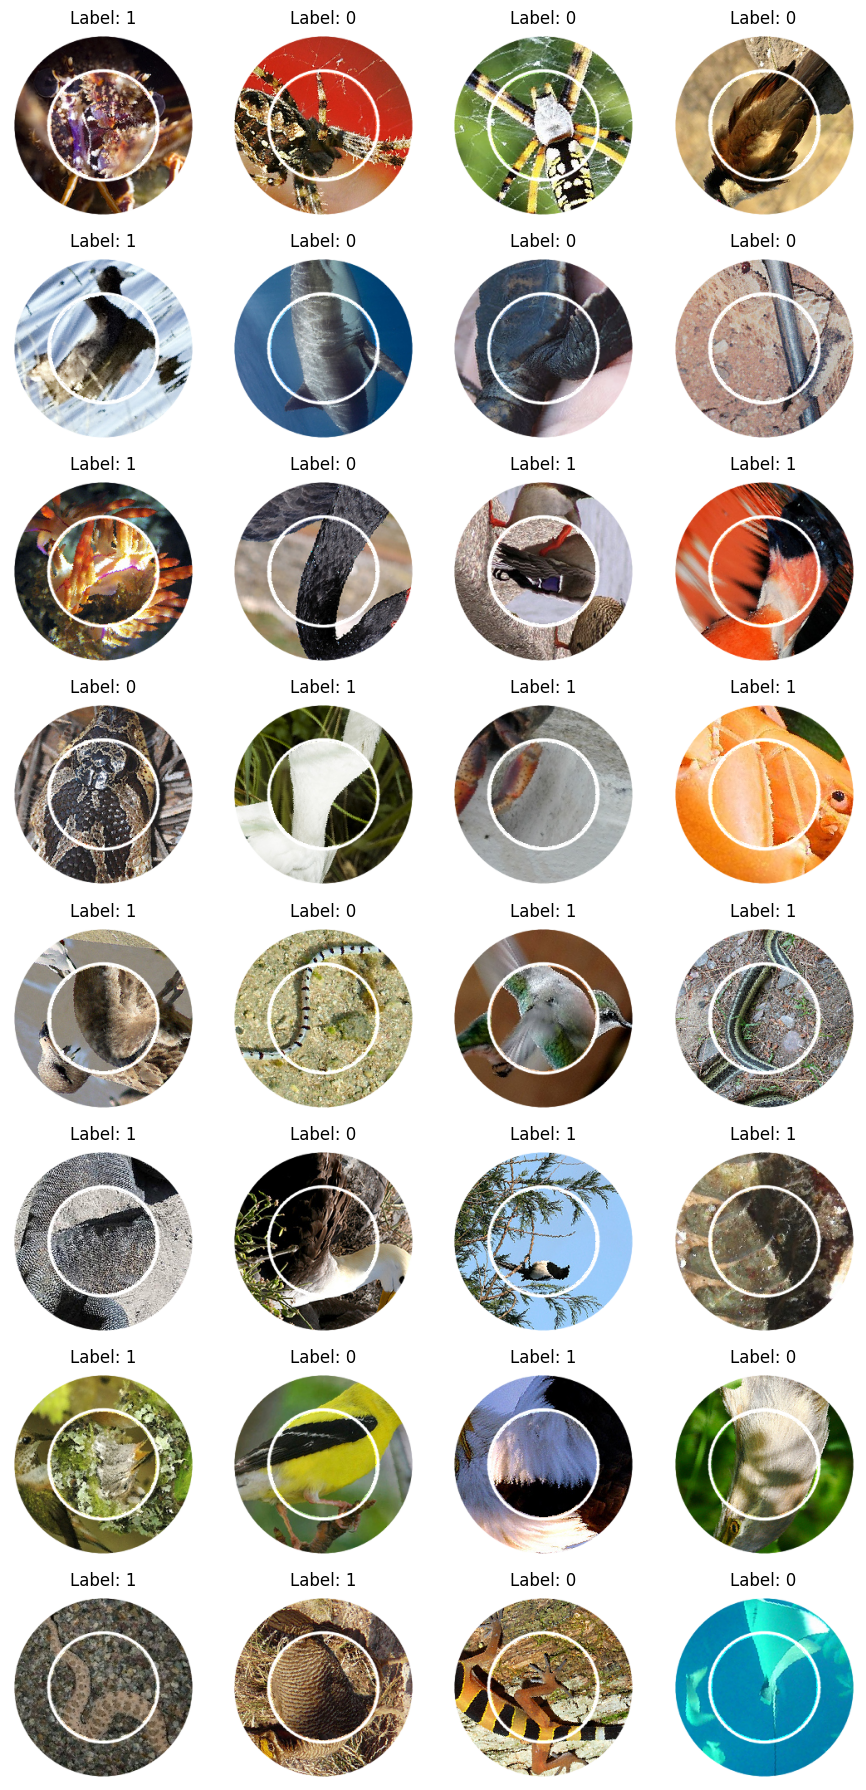

In [180]:
def show_example_images(dataloader, num_images=4):
    """
    Wyświetla przykładowe obrazy i etykiety z DataLoadera.

    Args:
        dataloader (DataLoader): PyTorch DataLoader zawierający dane.
        num_images (int): Liczba obrazów do wyświetlenia.
    """
    example_batch = next(iter(dataloader))
    example_data, example_labels = example_batch


    print(f'Example data shape: {example_data.shape}')
    print(f'Example labels: {example_labels[:num_images]}')


    cols = 4  
    rows = (num_images + cols - 1) // cols  

    plt.figure(figsize=(cols * 2.25, rows * 2.25)) # 75% of original size 

    # Wyświetlenie kilku obrazów z batcha
    for i in range(min(num_images, len(example_data))):
        img = example_data[i].permute(1, 2, 0).numpy()  # Permutacja, aby przekształcić do formatu HxWxC
        label = example_labels[i].item()
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("PreprocessedImages.png")
    plt.show()
    

show_example_images(train_dl, num_images=32)

# Probelm with very hard exapmles unsolvable for humans

In [149]:
def find_max_batch_size(model, input_size, start_batch_size=32, step=32):
    """
    find max batch, for GPU.

    Args:
        model (torch.nn.Module): Model 
        input_size (tuple): input size (np. (3, 224, 224) dla obrazu RGB 224x224).
        start_batch_size (int): Początkowy rozmiar batcha.
        step (int): Wartość o jaką zwiększa się batch_size w każdym kroku.

    Returns:
        int: Max batch size for GPU.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    batch_size = start_batch_size
    while True:
        try:
            print(f"Trying batch size: {batch_size}")
            inputs = torch.randn(batch_size, *input_size).to(device)
            outputs = model(inputs)  # Forward pass
            del inputs, outputs  # Zwolnij pamięć, gdy nie jest już potrzebna
            torch.cuda.empty_cache()  # Zwolnienie pamięci na GPU
            batch_size += step
        except RuntimeError as e:
            if 'out of memory' in str(e):
                print(f"Out of memory error at batch size: {batch_size}")
                batch_size -= step  # Zmniejszenie do poprzedniego, który działał
                print(f'Approximate maximum batch size: {batch_size}')
                break
            else:
                raise e
    
    return batch_size

#model = EfficientNet(latent_dim=512) # It is 12 milion param
#max_batch_size = find_max_batch_size(model, input_size=(3, 224, 224))
# For efficentnet 1024 as max batch size

#model = SwinV2T(latent_dim=512) # it is 28 milion param
#max_batch_size = find_max_batch_size(model, input_size=(3, 224, 224))
# For SwinV2T 512 as batch size



Trying batch size: 32
Trying batch size: 64
Trying batch size: 96
Trying batch size: 128
Trying batch size: 160
Trying batch size: 192
Trying batch size: 224
Trying batch size: 256
Trying batch size: 288
Trying batch size: 320
Trying batch size: 352
Trying batch size: 384
Trying batch size: 416
Trying batch size: 448
Trying batch size: 480
Trying batch size: 512
Trying batch size: 544
Trying batch size: 576
Trying batch size: 608
Trying batch size: 640
Trying batch size: 672
Trying batch size: 704
Trying batch size: 736
Trying batch size: 768


KeyboardInterrupt: 

In [182]:

#gc.collect()
#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats()

In [19]:
def calculate_log_interval(dataloader, percent=10):
    """
    Calculate the interval at which to log progress.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        percent (int): Percentage of total batches to determine log interval.

    Returns:
        int: Number of batches between log outputs.
    """
    num_batches = len(dataloader)
    log_interval = max(1, int(num_batches * percent / 100))
    print(f"Number of batches in dataset: {num_batches}, log interval: every {log_interval} batches.")
    return log_interval

xd = calculate_log_interval(train_dl, percent=10)

Number of batches in dataset: 705, log interval: every 70 batches.


### Train and test functions + imporved earlystopping

In [20]:
class EarlyStopping:
    '''
    Method for avoiding overfitting by stopping when validation loss doesn't decrease.

    '''
    def __init__(self, old_loss=float('inf'), patience=5, delta=0.001, save=False):
        '''
        Attributes
        ---------------------

        old_loss: float
            Initially set to infinity.
            Loss from the last epoch.
            You can use validation loss, accuracy, or your custom metric.

        patience: int
            Number of epochs to wait before stopping when no improvement.
        
        delta: float
            Minimum change in the monitored metric to qualify as an improvement.
        
        save: bool
            If True, saves the best model's weights.
            Saves the entire model (not just the weights).

        Parameters
        --------------------
        counter: int 0 
            If counter reaches patience, training stops.
        
        best_loss: float
            Saves the best weights.
        '''
        self.old_loss = old_loss
        self.patience = patience
        self.delta = delta
        self.save = save
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, new_loss, model=None):
        '''
        Args
        ------------------------
        model: torch.nn.Module
            Model to save weights.
        new_loss: float
            New loss after validation/testing.

        Returns
        -------------------
        bool:
            True if training should stop.
        
        Saves best model parameters or model file.
        '''
        if new_loss < self.old_loss:
            if (self.old_loss - new_loss) <= self.delta:
                self.counter += 1 
            else:
                # Reset counter if there is a significant decrease
                self.counter = 0
            self.old_loss = new_loss
        elif new_loss > self.old_loss:
            # Increment counter if no improvement
            self.counter += 1
        
        # Save best model
        if self.save:
            if new_loss <= self.best_loss:
                self.best_loss = new_loss
                torch.save(model, 'best_model.pth')
                
        # Stop training if patience is exceeded
        if self.counter >= self.patience:
            return True
        
        return False


In [23]:
def train_function(model, loss_fn, optimizer, dataloader, log_interval=None):
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): The neural network model to train.
        loss_fn (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer for adjusting model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        log_interval (int, optional): Interval for logging progress.

    Returns:
        float: Average training loss for the epoch.
        list: List of losses at each log interval.
    """
    model.train()
    total_loss = 0.0
    interval_loss = []
    num_batches = len(dataloader)

    for i, (data, label) in tqdm(enumerate(dataloader), total=num_batches, desc="Training"):
        data, label = data.to(device), label.to(device)#.float() # if sigomid has to be added

        optimizer.zero_grad()  # Clear gradients
        output = model(data).squeeze(1)
        loss = loss_fn(output, label)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize model parameters

        total_loss += loss.item()

        if log_interval and (i + 1) % log_interval == 0:
            avg_loss = total_loss / (i + 1)
            tqdm.write(f"Batch {i + 1}/{num_batches}, Train Loss: {avg_loss:.4f}")
            interval_loss.append(avg_loss)

    avg_epoch_loss = total_loss / num_batches
    return avg_epoch_loss, interval_loss
    
def test_function(model, loss_fn, dataloader):
    """
    Evaluate the model on the test set.

    Args:
        model (torch.nn.Module): The neural network model to evaluate.
        loss_fn (torch.nn.Module): The loss function.
        dataloader (torch.utils.data.DataLoader): DataLoader for test data.

    Returns:
        float: Average test loss.
        float: Test accuracy.
    """
    model.eval()
    total_loss = 0.0
    correct = 0.0
    num_batches = len(dataloader)
    size = len(dataloader.dataset)

    with torch.no_grad():
        for data, label in tqdm(dataloader, total=num_batches, desc="Testing"):
            data, label = data.to(device), label.to(device).long()
            output = model(data)

            # Dodawanie straty
            total_loss += loss_fn(output, label).item()

            # Przekształcanie wyjścia na przewidywanie klasy (0 lub 1)
            predicted = output.argmax(dim=1, keepdim=True)
            correct += predicted.eq(label.view_as(predicted)).sum().item()

    avg_loss = total_loss / num_batches
    accuracy = correct / size
    return avg_loss, accuracy


def train_model(epochs, model, loss_fn, optimizer, train_dataloader, test_dataloader, scheduler=None, start_epoch=0, log_interval=None, patience=3):
    """
    Train the model over a specified number of epochs, with early stopping.

    Args:
        epochs (int): Number of epochs to train the model.
        model (torch.nn.Module): The neural network model to train.
        loss_fn (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer for adjusting model parameters.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for test data.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler.
        start_epoch (int, optional): Epoch number to start training from.
        log_interval (int, optional): Interval for logging progress during training.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped.

    Returns:
        tuple: (train_losses, test_losses, accuracies, base_loss, all_interval_losses)
    """
    if scheduler is not None:
        for _ in range(start_epoch):
            scheduler.step()

    all_interval_losses = []
    early_stopping = EarlyStopping(patience=patience, save=True)
    base_loss, _ = test_function(model, loss_fn, test_dataloader)  # Initial test loss without training
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    accuracies = np.zeros(epochs)

    for epoch in range(epochs):
        start_time = time.time()
        train_loss, interval_loss = train_function(model, loss_fn, optimizer, train_dataloader, log_interval)
        train_time = time.time() - start_time

        test_loss, accuracy = test_function(model, loss_fn, test_dataloader)
        test_time = time.time() - start_time - train_time

        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        accuracies[epoch] = accuracy
        all_interval_losses.append(interval_loss)

        if scheduler is not None:
            scheduler.step()

        print(f"EPOCH {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Train/Test Time: {train_time:.2f}/{test_time:.2f} sec")

        if early_stopping(test_loss, model):
            print("Early stopping triggered.")
            train_losses = np.trim_zeros(train_losses, 'b')
            test_losses = np.trim_zeros(test_losses, 'b')
            accuracies = np.trim_zeros(accuracies, 'b')
            break

    return train_losses, test_losses, accuracies, base_loss, all_interval_losses


In [22]:
#criterion = nn.BCEWithLogitsLoss() # Sigmoid built in 
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)
model = EfficientNet(latent_dim=512)
model.to(device)
#latent_dim = 512
#embedding_model = EmbeddingNet(latent_dim=latent_dim, architecture=18).to(device)
#model_classification = ClassificationNet(embedding_model, 360, latent_dim=latent_dim).to(device)

NameError: name 'model' is not defined

In [202]:
train_losses, test_losses, accuracies, base_loss, all_interval_losses = train_model(epoch,
                                                                                    model,
                                                                                    criterion,
                                                                                    optimizer,
                                                                                    train_dl,
                                                                                    test_dl,
                                                                                    scheduler,
                                                                                    start_epoch=0,
                                                                                    log_interval=35,
                                                                                    patience=4)
# Add saving to file as looger

Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:17<05:55,  1.89it/s]

Batch 35/705, Train Loss: 0.6232


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:36<05:28,  1.93it/s]

Batch 70/705, Train Loss: 0.5523


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:54<05:16,  1.90it/s]

Batch 105/705, Train Loss: 0.5282


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:13<05:08,  1.83it/s]

Batch 140/705, Train Loss: 0.5117


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:31<04:33,  1.94it/s]

Batch 175/705, Train Loss: 0.4939


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:49<04:06,  2.01it/s]

Batch 210/705, Train Loss: 0.4844


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:07<03:56,  1.95it/s]

Batch 245/705, Train Loss: 0.4779


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:25<03:38,  1.95it/s]

Batch 280/705, Train Loss: 0.4721


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:43<03:22,  1.93it/s]

Batch 315/705, Train Loss: 0.4692


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:01<03:07,  1.90it/s]

Batch 350/705, Train Loss: 0.4645


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:20<02:59,  1.78it/s]

Batch 385/705, Train Loss: 0.4610


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:38<02:31,  1.88it/s]

Batch 420/705, Train Loss: 0.4585


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [03:57<02:19,  1.80it/s]

Batch 455/705, Train Loss: 0.4554


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:15<01:53,  1.90it/s]

Batch 490/705, Train Loss: 0.4531


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:33<01:33,  1.93it/s]

Batch 525/705, Train Loss: 0.4509


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [04:52<01:19,  1.83it/s]

Batch 560/705, Train Loss: 0.4490


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:10<00:57,  1.91it/s]

Batch 595/705, Train Loss: 0.4462


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:29<00:38,  1.92it/s]

Batch 630/705, Train Loss: 0.4446


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [05:47<00:20,  1.93it/s]

Batch 665/705, Train Loss: 0.4427


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:05<00:02,  1.89it/s]

Batch 700/705, Train Loss: 0.4405


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:16<00:00,  1.96it/s]


EPOCH 1/15: Train Loss: 0.4407, Test Loss: 0.3761, Accuracy: 0.8335, Train/Test Time: 367.83/76.94 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:18<05:51,  1.91it/s]

Batch 35/705, Train Loss: 0.4250


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:36<05:32,  1.91it/s]

Batch 70/705, Train Loss: 0.4210


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:54<05:15,  1.90it/s]

Batch 105/705, Train Loss: 0.4211


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:12<04:58,  1.90it/s]

Batch 140/705, Train Loss: 0.4156


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:30<04:41,  1.89it/s]

Batch 175/705, Train Loss: 0.4120


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:49<04:16,  1.93it/s]

Batch 210/705, Train Loss: 0.4103


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:07<03:56,  1.94it/s]

Batch 245/705, Train Loss: 0.4093


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:26<03:34,  1.98it/s]

Batch 280/705, Train Loss: 0.4106


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:44<03:22,  1.93it/s]

Batch 315/705, Train Loss: 0.4100


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:02<03:07,  1.90it/s]

Batch 350/705, Train Loss: 0.4099


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:20<02:45,  1.93it/s]

Batch 385/705, Train Loss: 0.4102


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:39<02:31,  1.88it/s]

Batch 420/705, Train Loss: 0.4092


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [03:57<02:08,  1.95it/s]

Batch 455/705, Train Loss: 0.4086


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:15<01:47,  2.00it/s]

Batch 490/705, Train Loss: 0.4086


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:34<01:35,  1.88it/s]

Batch 525/705, Train Loss: 0.4077


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [04:54<01:18,  1.85it/s]

Batch 560/705, Train Loss: 0.4072


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:12<00:57,  1.91it/s]

Batch 595/705, Train Loss: 0.4071


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:31<00:39,  1.92it/s]

Batch 630/705, Train Loss: 0.4068


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [05:49<00:20,  1.95it/s]

Batch 665/705, Train Loss: 0.4062


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:08<00:02,  1.93it/s]

Batch 700/705, Train Loss: 0.4056


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:18<00:00,  1.94it/s]


EPOCH 2/15: Train Loss: 0.4052, Test Loss: 0.3803, Accuracy: 0.8340, Train/Test Time: 370.25/78.02 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:18<05:59,  1.86it/s]

Batch 35/705, Train Loss: 0.4008


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:36<05:31,  1.91it/s]

Batch 70/705, Train Loss: 0.4110


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:55<05:19,  1.88it/s]

Batch 105/705, Train Loss: 0.4038


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:13<04:46,  1.97it/s]

Batch 140/705, Train Loss: 0.4011


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:31<04:41,  1.88it/s]

Batch 175/705, Train Loss: 0.4009


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:50<04:15,  1.93it/s]

Batch 210/705, Train Loss: 0.3990


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:08<04:08,  1.85it/s]

Batch 245/705, Train Loss: 0.3997


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:27<03:43,  1.90it/s]

Batch 280/705, Train Loss: 0.4014


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:45<03:24,  1.91it/s]

Batch 315/705, Train Loss: 0.4005


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:04<03:09,  1.87it/s]

Batch 350/705, Train Loss: 0.3997


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:22<02:47,  1.91it/s]

Batch 385/705, Train Loss: 0.3990


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:40<02:27,  1.94it/s]

Batch 420/705, Train Loss: 0.3967


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [03:59<02:08,  1.95it/s]

Batch 455/705, Train Loss: 0.3956


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:17<01:55,  1.86it/s]

Batch 490/705, Train Loss: 0.3952


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:36<01:32,  1.95it/s]

Batch 525/705, Train Loss: 0.3956


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [04:54<01:14,  1.94it/s]

Batch 560/705, Train Loss: 0.3955


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:12<00:58,  1.89it/s]

Batch 595/705, Train Loss: 0.3946


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:30<00:38,  1.93it/s]

Batch 630/705, Train Loss: 0.3953


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [05:49<00:20,  1.91it/s]

Batch 665/705, Train Loss: 0.3951


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:07<00:02,  1.90it/s]

Batch 700/705, Train Loss: 0.3947


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:17<00:00,  1.94it/s]


EPOCH 3/15: Train Loss: 0.3951, Test Loss: 0.3658, Accuracy: 0.8412, Train/Test Time: 369.69/77.83 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:18<05:52,  1.90it/s]

Batch 35/705, Train Loss: 0.3963


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:36<05:40,  1.87it/s]

Batch 70/705, Train Loss: 0.3840


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:55<05:31,  1.81it/s]

Batch 105/705, Train Loss: 0.3816


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:14<05:00,  1.88it/s]

Batch 140/705, Train Loss: 0.3813


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:33<04:49,  1.83it/s]

Batch 175/705, Train Loss: 0.3836


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:52<04:23,  1.88it/s]

Batch 210/705, Train Loss: 0.3843


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:10<03:51,  1.99it/s]

Batch 245/705, Train Loss: 0.3848


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:28<03:37,  1.96it/s]

Batch 280/705, Train Loss: 0.3868


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:46<03:26,  1.89it/s]

Batch 315/705, Train Loss: 0.3864


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:04<03:05,  1.91it/s]

Batch 350/705, Train Loss: 0.3861


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:23<02:44,  1.95it/s]

Batch 385/705, Train Loss: 0.3869


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:41<02:24,  1.97it/s]

Batch 420/705, Train Loss: 0.3863


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [03:59<02:08,  1.94it/s]

Batch 455/705, Train Loss: 0.3870


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:17<01:49,  1.97it/s]

Batch 490/705, Train Loss: 0.3872


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:36<01:38,  1.84it/s]

Batch 525/705, Train Loss: 0.3879


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [04:54<01:15,  1.93it/s]

Batch 560/705, Train Loss: 0.3888


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:12<00:56,  1.94it/s]

Batch 595/705, Train Loss: 0.3901


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:33<00:46,  1.62it/s]

Batch 630/705, Train Loss: 0.3885


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [05:52<00:21,  1.88it/s]

Batch 665/705, Train Loss: 0.3884


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:12<00:02,  1.72it/s]

Batch 700/705, Train Loss: 0.3878


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:20<00:00,  1.89it/s]


EPOCH 4/15: Train Loss: 0.3874, Test Loss: 0.3651, Accuracy: 0.8443, Train/Test Time: 374.43/80.09 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:18<05:43,  1.95it/s]

Batch 35/705, Train Loss: 0.3975


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:36<05:37,  1.88it/s]

Batch 70/705, Train Loss: 0.4038


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:54<05:26,  1.84it/s]

Batch 105/705, Train Loss: 0.3933


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:13<04:42,  2.00it/s]

Batch 140/705, Train Loss: 0.3892


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:33<05:59,  1.47it/s]

Batch 175/705, Train Loss: 0.3857


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:55<05:22,  1.53it/s]

Batch 210/705, Train Loss: 0.3858


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:15<04:07,  1.86it/s]

Batch 245/705, Train Loss: 0.3867


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:36<04:14,  1.67it/s]

Batch 280/705, Train Loss: 0.3856


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:57<04:11,  1.55it/s]

Batch 315/705, Train Loss: 0.3866


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:21<04:05,  1.45it/s]

Batch 350/705, Train Loss: 0.3867


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:46<04:08,  1.29it/s]

Batch 385/705, Train Loss: 0.3864


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [04:13<03:28,  1.37it/s]

Batch 420/705, Train Loss: 0.3866


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:41<03:15,  1.28it/s]

Batch 455/705, Train Loss: 0.3864


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [05:06<02:29,  1.43it/s]

Batch 490/705, Train Loss: 0.3875


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [05:31<02:00,  1.49it/s]

Batch 525/705, Train Loss: 0.3880


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [05:56<01:53,  1.28it/s]

Batch 560/705, Train Loss: 0.3891


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [06:22<01:14,  1.48it/s]

Batch 595/705, Train Loss: 0.3886


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [06:46<00:57,  1.32it/s]

Batch 630/705, Train Loss: 0.3879


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [07:11<00:28,  1.42it/s]

Batch 665/705, Train Loss: 0.3876


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [07:34<00:03,  1.50it/s]

Batch 700/705, Train Loss: 0.3879


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:40<00:00,  1.51it/s]


EPOCH 5/15: Train Loss: 0.3883, Test Loss: 0.3697, Accuracy: 0.8481, Train/Test Time: 457.39/100.21 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:23<07:50,  1.42it/s]

Batch 35/705, Train Loss: 0.3848


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:46<07:11,  1.47it/s]

Batch 70/705, Train Loss: 0.3751


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [01:09<06:36,  1.51it/s]

Batch 105/705, Train Loss: 0.3793


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:32<06:18,  1.49it/s]

Batch 140/705, Train Loss: 0.3808


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:56<06:06,  1.45it/s]

Batch 175/705, Train Loss: 0.3827


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [02:19<05:35,  1.48it/s]

Batch 210/705, Train Loss: 0.3805


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:43<05:14,  1.46it/s]

Batch 245/705, Train Loss: 0.3791


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [03:07<05:00,  1.41it/s]

Batch 280/705, Train Loss: 0.3797


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [03:32<04:43,  1.38it/s]

Batch 315/705, Train Loss: 0.3806


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:56<04:23,  1.34it/s]

Batch 350/705, Train Loss: 0.3798


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [04:21<03:45,  1.42it/s]

Batch 385/705, Train Loss: 0.3796


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [04:46<03:19,  1.43it/s]

Batch 420/705, Train Loss: 0.3795


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [05:11<03:00,  1.38it/s]

Batch 455/705, Train Loss: 0.3804


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [05:37<02:35,  1.38it/s]

Batch 490/705, Train Loss: 0.3820


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [06:02<02:09,  1.39it/s]

Batch 525/705, Train Loss: 0.3812


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [06:29<01:50,  1.31it/s]

Batch 560/705, Train Loss: 0.3815


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [06:54<01:19,  1.38it/s]

Batch 595/705, Train Loss: 0.3807


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [07:20<00:54,  1.38it/s]

Batch 630/705, Train Loss: 0.3808


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [07:46<00:29,  1.37it/s]

Batch 665/705, Train Loss: 0.3812


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [08:12<00:03,  1.31it/s]

Batch 700/705, Train Loss: 0.3813


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:24<00:00,  1.78it/s]


EPOCH 6/15: Train Loss: 0.3814, Test Loss: 0.3630, Accuracy: 0.8499, Train/Test Time: 495.67/84.69 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:18<06:08,  1.82it/s]

Batch 35/705, Train Loss: 0.3969


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:37<05:27,  1.94it/s]

Batch 70/705, Train Loss: 0.3830


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:56<05:28,  1.83it/s]

Batch 105/705, Train Loss: 0.3824


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:15<05:06,  1.84it/s]

Batch 140/705, Train Loss: 0.3817


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:33<04:42,  1.88it/s]

Batch 175/705, Train Loss: 0.3805


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:53<04:31,  1.83it/s]

Batch 210/705, Train Loss: 0.3785


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:13<04:31,  1.69it/s]

Batch 245/705, Train Loss: 0.3784


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:32<03:56,  1.80it/s]

Batch 280/705, Train Loss: 0.3789


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:50<03:22,  1.92it/s]

Batch 315/705, Train Loss: 0.3775


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:10<03:06,  1.91it/s]

Batch 350/705, Train Loss: 0.3774


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:29<02:45,  1.93it/s]

Batch 385/705, Train Loss: 0.3778


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:47<02:29,  1.91it/s]

Batch 420/705, Train Loss: 0.3775


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:06<02:13,  1.88it/s]

Batch 455/705, Train Loss: 0.3776


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:25<01:53,  1.90it/s]

Batch 490/705, Train Loss: 0.3775


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:43<01:34,  1.90it/s]

Batch 525/705, Train Loss: 0.3786


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [05:02<01:19,  1.82it/s]

Batch 560/705, Train Loss: 0.3790


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:21<00:58,  1.87it/s]

Batch 595/705, Train Loss: 0.3787


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:40<00:41,  1.82it/s]

Batch 630/705, Train Loss: 0.3794


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [05:59<00:20,  1.90it/s]

Batch 665/705, Train Loss: 0.3794


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:18<00:02,  1.79it/s]

Batch 700/705, Train Loss: 0.3799


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:19<00:00,  1.91it/s]


EPOCH 7/15: Train Loss: 0.3800, Test Loss: 0.3691, Accuracy: 0.8473, Train/Test Time: 380.63/79.17 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:18<05:43,  1.95it/s]

Batch 35/705, Train Loss: 0.3764


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:36<05:30,  1.92it/s]

Batch 70/705, Train Loss: 0.3739


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:55<05:24,  1.85it/s]

Batch 105/705, Train Loss: 0.3755


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:14<05:00,  1.88it/s]

Batch 140/705, Train Loss: 0.3776


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:32<04:40,  1.89it/s]

Batch 175/705, Train Loss: 0.3810


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:51<04:27,  1.85it/s]

Batch 210/705, Train Loss: 0.3798


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:09<04:01,  1.90it/s]

Batch 245/705, Train Loss: 0.3791


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:27<03:35,  1.97it/s]

Batch 280/705, Train Loss: 0.3779


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:46<03:20,  1.94it/s]

Batch 315/705, Train Loss: 0.3804


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:04<03:03,  1.93it/s]

Batch 350/705, Train Loss: 0.3809


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:23<02:47,  1.91it/s]

Batch 385/705, Train Loss: 0.3816


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:41<02:27,  1.94it/s]

Batch 420/705, Train Loss: 0.3814


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:00<02:13,  1.87it/s]

Batch 455/705, Train Loss: 0.3807


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:18<01:52,  1.90it/s]

Batch 490/705, Train Loss: 0.3803


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:37<01:34,  1.90it/s]

Batch 525/705, Train Loss: 0.3804


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [04:55<01:15,  1.91it/s]

Batch 560/705, Train Loss: 0.3796


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:14<01:00,  1.81it/s]

Batch 595/705, Train Loss: 0.3797


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:32<00:38,  1.96it/s]

Batch 630/705, Train Loss: 0.3793


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [05:50<00:21,  1.88it/s]

Batch 665/705, Train Loss: 0.3785


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:09<00:02,  1.83it/s]

Batch 700/705, Train Loss: 0.3790


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:18<00:00,  1.94it/s]


EPOCH 8/15: Train Loss: 0.3796, Test Loss: 0.3461, Accuracy: 0.8505, Train/Test Time: 371.69/78.02 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:18<05:57,  1.87it/s]

Batch 35/705, Train Loss: 0.3663


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:37<05:27,  1.94it/s]

Batch 70/705, Train Loss: 0.3729


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:56<05:27,  1.83it/s]

Batch 105/705, Train Loss: 0.3677


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:14<04:55,  1.91it/s]

Batch 140/705, Train Loss: 0.3657


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:33<04:37,  1.91it/s]

Batch 175/705, Train Loss: 0.3694


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:51<04:25,  1.87it/s]

Batch 210/705, Train Loss: 0.3663


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:10<04:00,  1.92it/s]

Batch 245/705, Train Loss: 0.3680


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:28<03:43,  1.90it/s]

Batch 280/705, Train Loss: 0.3693


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:47<03:26,  1.89it/s]

Batch 315/705, Train Loss: 0.3691


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:05<03:01,  1.96it/s]

Batch 350/705, Train Loss: 0.3687


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:23<02:47,  1.91it/s]

Batch 385/705, Train Loss: 0.3687


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:41<02:28,  1.93it/s]

Batch 420/705, Train Loss: 0.3687


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:00<02:14,  1.86it/s]

Batch 455/705, Train Loss: 0.3676


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:19<02:04,  1.73it/s]

Batch 490/705, Train Loss: 0.3672


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:40<01:42,  1.76it/s]

Batch 525/705, Train Loss: 0.3678


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [04:59<01:15,  1.92it/s]

Batch 560/705, Train Loss: 0.3673


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:17<00:56,  1.94it/s]

Batch 595/705, Train Loss: 0.3679


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:36<00:38,  1.95it/s]

Batch 630/705, Train Loss: 0.3677


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [05:54<00:21,  1.90it/s]

Batch 665/705, Train Loss: 0.3680


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:13<00:02,  1.93it/s]

Batch 700/705, Train Loss: 0.3675


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:18<00:00,  1.93it/s]


EPOCH 9/15: Train Loss: 0.3681, Test Loss: 0.5969, Accuracy: 0.8541, Train/Test Time: 375.26/78.34 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:18<05:58,  1.87it/s]

Batch 35/705, Train Loss: 0.3848


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:36<05:33,  1.90it/s]

Batch 70/705, Train Loss: 0.3727


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:54<05:11,  1.93it/s]

Batch 105/705, Train Loss: 0.3707


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:13<05:01,  1.88it/s]

Batch 140/705, Train Loss: 0.3670


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:32<05:03,  1.74it/s]

Batch 175/705, Train Loss: 0.3649


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:50<04:11,  1.96it/s]

Batch 210/705, Train Loss: 0.3626


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:08<04:05,  1.87it/s]

Batch 245/705, Train Loss: 0.3648


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:27<03:45,  1.89it/s]

Batch 280/705, Train Loss: 0.3648


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:45<03:43,  1.75it/s]

Batch 315/705, Train Loss: 0.3650


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:04<03:12,  1.85it/s]

Batch 350/705, Train Loss: 0.3641


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:23<03:01,  1.76it/s]

Batch 385/705, Train Loss: 0.3641


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:42<02:34,  1.85it/s]

Batch 420/705, Train Loss: 0.3654


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:00<02:11,  1.90it/s]

Batch 455/705, Train Loss: 0.3669


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:19<01:57,  1.83it/s]

Batch 490/705, Train Loss: 0.3670


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:38<01:40,  1.79it/s]

Batch 525/705, Train Loss: 0.3665


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [04:57<01:18,  1.85it/s]

Batch 560/705, Train Loss: 0.3665


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:17<01:00,  1.82it/s]

Batch 595/705, Train Loss: 0.3673


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:36<00:39,  1.91it/s]

Batch 630/705, Train Loss: 0.3672


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [05:55<00:21,  1.87it/s]

Batch 665/705, Train Loss: 0.3666


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:14<00:02,  1.77it/s]

Batch 700/705, Train Loss: 0.3667


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:21<00:00,  1.84it/s]


EPOCH 10/15: Train Loss: 0.3666, Test Loss: 0.3425, Accuracy: 0.8521, Train/Test Time: 377.08/81.89 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:19<06:09,  1.81it/s]

Batch 35/705, Train Loss: 0.3648


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:38<05:36,  1.88it/s]

Batch 70/705, Train Loss: 0.3652


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:56<05:20,  1.87it/s]

Batch 105/705, Train Loss: 0.3604


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:16<05:19,  1.77it/s]

Batch 140/705, Train Loss: 0.3592


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:35<04:40,  1.89it/s]

Batch 175/705, Train Loss: 0.3606


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:55<04:35,  1.80it/s]

Batch 210/705, Train Loss: 0.3605


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:15<04:25,  1.73it/s]

Batch 245/705, Train Loss: 0.3609


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:35<04:14,  1.67it/s]

Batch 280/705, Train Loss: 0.3622


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:55<03:44,  1.74it/s]

Batch 315/705, Train Loss: 0.3624


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:15<03:17,  1.80it/s]

Batch 350/705, Train Loss: 0.3616


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:35<03:14,  1.65it/s]

Batch 385/705, Train Loss: 0.3621


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:55<02:42,  1.76it/s]

Batch 420/705, Train Loss: 0.3610


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:15<02:21,  1.77it/s]

Batch 455/705, Train Loss: 0.3609


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:35<02:15,  1.59it/s]

Batch 490/705, Train Loss: 0.3611


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:57<01:45,  1.71it/s]

Batch 525/705, Train Loss: 0.3609


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [05:17<01:19,  1.82it/s]

Batch 560/705, Train Loss: 0.3618


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:37<00:59,  1.84it/s]

Batch 595/705, Train Loss: 0.3613


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:56<00:41,  1.79it/s]

Batch 630/705, Train Loss: 0.3615


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [06:17<00:23,  1.70it/s]

Batch 665/705, Train Loss: 0.3608


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:37<00:02,  1.73it/s]

Batch 700/705, Train Loss: 0.3598


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:20<00:00,  1.88it/s]


EPOCH 11/15: Train Loss: 0.3596, Test Loss: 0.3467, Accuracy: 0.8508, Train/Test Time: 400.32/80.34 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:19<06:07,  1.82it/s]

Batch 35/705, Train Loss: 0.3681


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:39<06:16,  1.69it/s]

Batch 70/705, Train Loss: 0.3635


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:58<05:22,  1.86it/s]

Batch 105/705, Train Loss: 0.3580


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:18<05:04,  1.86it/s]

Batch 140/705, Train Loss: 0.3617


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:37<04:55,  1.79it/s]

Batch 175/705, Train Loss: 0.3640


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:56<04:37,  1.79it/s]

Batch 210/705, Train Loss: 0.3641


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:15<04:05,  1.88it/s]

Batch 245/705, Train Loss: 0.3644


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:34<03:50,  1.84it/s]

Batch 280/705, Train Loss: 0.3645


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:53<03:36,  1.81it/s]

Batch 315/705, Train Loss: 0.3640


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:13<03:31,  1.68it/s]

Batch 350/705, Train Loss: 0.3647


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:33<02:59,  1.79it/s]

Batch 385/705, Train Loss: 0.3643


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:53<02:38,  1.80it/s]

Batch 420/705, Train Loss: 0.3649


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:14<02:39,  1.57it/s]

Batch 455/705, Train Loss: 0.3647


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:36<02:30,  1.42it/s]

Batch 490/705, Train Loss: 0.3656


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:58<01:53,  1.59it/s]

Batch 525/705, Train Loss: 0.3654


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [05:19<01:22,  1.76it/s]

Batch 560/705, Train Loss: 0.3646


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:39<01:03,  1.74it/s]

Batch 595/705, Train Loss: 0.3636


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:59<00:42,  1.74it/s]

Batch 630/705, Train Loss: 0.3629


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [06:19<00:22,  1.78it/s]

Batch 665/705, Train Loss: 0.3625


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:39<00:02,  1.72it/s]

Batch 700/705, Train Loss: 0.3622


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:22<00:00,  1.83it/s]


EPOCH 12/15: Train Loss: 0.3624, Test Loss: 0.3381, Accuracy: 0.8588, Train/Test Time: 402.22/82.65 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:19<06:17,  1.78it/s]

Batch 35/705, Train Loss: 0.3710


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:39<06:06,  1.73it/s]

Batch 70/705, Train Loss: 0.3667


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:59<05:38,  1.77it/s]

Batch 105/705, Train Loss: 0.3672


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:19<05:21,  1.76it/s]

Batch 140/705, Train Loss: 0.3674


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:39<05:11,  1.70it/s]

Batch 175/705, Train Loss: 0.3687


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:59<04:40,  1.77it/s]

Batch 210/705, Train Loss: 0.3665


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:19<04:30,  1.70it/s]

Batch 245/705, Train Loss: 0.3654


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:39<04:03,  1.75it/s]

Batch 280/705, Train Loss: 0.3652


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:59<03:51,  1.68it/s]

Batch 315/705, Train Loss: 0.3636


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:19<03:14,  1.82it/s]

Batch 350/705, Train Loss: 0.3643


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:39<03:08,  1.70it/s]

Batch 385/705, Train Loss: 0.3647


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [04:00<02:47,  1.70it/s]

Batch 420/705, Train Loss: 0.3646


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:19<02:16,  1.83it/s]

Batch 455/705, Train Loss: 0.3653


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:39<01:59,  1.79it/s]

Batch 490/705, Train Loss: 0.3646


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:59<01:41,  1.77it/s]

Batch 525/705, Train Loss: 0.3644


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [05:19<01:21,  1.77it/s]

Batch 560/705, Train Loss: 0.3647


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:39<01:02,  1.75it/s]

Batch 595/705, Train Loss: 0.3638


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:59<00:44,  1.70it/s]

Batch 630/705, Train Loss: 0.3646


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [06:19<00:22,  1.82it/s]

Batch 665/705, Train Loss: 0.3636


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:38<00:02,  1.82it/s]

Batch 700/705, Train Loss: 0.3627


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:22<00:00,  1.83it/s]


EPOCH 13/15: Train Loss: 0.3629, Test Loss: 0.3343, Accuracy: 0.8577, Train/Test Time: 401.01/82.69 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:19<06:11,  1.80it/s]

Batch 35/705, Train Loss: 0.3599


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:40<06:11,  1.71it/s]

Batch 70/705, Train Loss: 0.3658


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:59<05:46,  1.73it/s]

Batch 105/705, Train Loss: 0.3585


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:19<05:28,  1.72it/s]

Batch 140/705, Train Loss: 0.3624


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:39<04:56,  1.79it/s]

Batch 175/705, Train Loss: 0.3615


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:59<04:29,  1.84it/s]

Batch 210/705, Train Loss: 0.3619


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:19<04:16,  1.79it/s]

Batch 245/705, Train Loss: 0.3616


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:39<03:59,  1.78it/s]

Batch 280/705, Train Loss: 0.3620


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:58<03:47,  1.72it/s]

Batch 315/705, Train Loss: 0.3622


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:18<03:12,  1.84it/s]

Batch 350/705, Train Loss: 0.3618


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:37<02:58,  1.80it/s]

Batch 385/705, Train Loss: 0.3633


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:56<02:29,  1.91it/s]

Batch 420/705, Train Loss: 0.3609


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:15<02:12,  1.89it/s]

Batch 455/705, Train Loss: 0.3604


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:35<02:09,  1.66it/s]

Batch 490/705, Train Loss: 0.3607


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:53<01:40,  1.79it/s]

Batch 525/705, Train Loss: 0.3599


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [05:13<01:24,  1.72it/s]

Batch 560/705, Train Loss: 0.3610


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:33<01:02,  1.75it/s]

Batch 595/705, Train Loss: 0.3608


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:52<00:44,  1.69it/s]

Batch 630/705, Train Loss: 0.3604


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [06:11<00:21,  1.90it/s]

Batch 665/705, Train Loss: 0.3598


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:30<00:02,  1.83it/s]

Batch 700/705, Train Loss: 0.3605


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:18<00:00,  1.93it/s]


EPOCH 14/15: Train Loss: 0.3608, Test Loss: 0.3334, Accuracy: 0.8570, Train/Test Time: 392.95/78.41 sec


Training:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                                        | 35/705 [00:19<06:13,  1.79it/s]

Batch 35/705, Train Loss: 0.3442


Training:  10%|██████████████████████████████████▎                                                                                                                                                                                                                                                                                                                       | 70/705 [00:38<05:47,  1.83it/s]

Batch 70/705, Train Loss: 0.3510


Training:  15%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                     | 105/705 [00:57<05:24,  1.85it/s]

Batch 105/705, Train Loss: 0.3516


Training:  20%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                    | 140/705 [01:16<04:56,  1.90it/s]

Batch 140/705, Train Loss: 0.3499


Training:  25%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 175/705 [01:34<04:46,  1.85it/s]

Batch 175/705, Train Loss: 0.3520


Training:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 210/705 [01:54<04:52,  1.69it/s]

Batch 210/705, Train Loss: 0.3548


Training:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 245/705 [02:13<04:21,  1.76it/s]

Batch 245/705, Train Loss: 0.3546


Training:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 280/705 [02:32<04:04,  1.74it/s]

Batch 280/705, Train Loss: 0.3541


Training:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 315/705 [02:52<03:41,  1.76it/s]

Batch 315/705, Train Loss: 0.3557


Training:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 350/705 [03:10<03:14,  1.82it/s]

Batch 350/705, Train Loss: 0.3565


Training:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 385/705 [03:29<02:52,  1.85it/s]

Batch 385/705, Train Loss: 0.3561


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 420/705 [03:48<02:37,  1.81it/s]

Batch 420/705, Train Loss: 0.3571


Training:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 455/705 [04:07<02:17,  1.82it/s]

Batch 455/705, Train Loss: 0.3565


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 490/705 [04:26<01:57,  1.82it/s]

Batch 490/705, Train Loss: 0.3558


Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 525/705 [04:45<01:37,  1.85it/s]

Batch 525/705, Train Loss: 0.3554


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 560/705 [05:03<01:20,  1.80it/s]

Batch 560/705, Train Loss: 0.3553


Training:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 595/705 [05:22<00:59,  1.85it/s]

Batch 595/705, Train Loss: 0.3556


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 630/705 [05:42<00:41,  1.83it/s]

Batch 630/705, Train Loss: 0.3549


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 665/705 [06:01<00:22,  1.79it/s]

Batch 665/705, Train Loss: 0.3550


Training:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 700/705 [06:20<00:02,  1.84it/s]

Batch 700/705, Train Loss: 0.3547


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [01:19<00:00,  1.91it/s]

EPOCH 15/15: Train Loss: 0.3549, Test Loss: 0.3491, Accuracy: 0.8545, Train/Test Time: 383.27/79.02 sec


In [206]:
base_loss

0.6932622478497739

In [203]:
train_losses

array([0.44072998, 0.4051738 , 0.39508066, 0.38743863, 0.38828381,
       0.38138344, 0.38003159, 0.37958754, 0.36806029, 0.36660111,
       0.35963523, 0.36241323, 0.36285479, 0.36082635, 0.35491002])

In [204]:
test_losses

array([0.37609134, 0.38034076, 0.3657657 , 0.36508681, 0.36970699,
       0.36299237, 0.36913033, 0.34614947, 0.59685408, 0.34246178,
       0.34674937, 0.33807095, 0.33428417, 0.33344008, 0.34910497])

In [205]:
accuracies

array([0.83351458, 0.83398063, 0.8411786 , 0.84433742, 0.84811765,
       0.84987831, 0.84734089, 0.85049972, 0.85407281, 0.85210502,
       0.85081042, 0.85883693, 0.85774947, 0.85702449, 0.85448708])

In [207]:
all_interval_losses

[[0.623185715505055,
  0.5522650718688965,
  0.5281760979266393,
  0.5116943895816803,
  0.4938939801284245,
  0.48444932798544565,
  0.4779035860178422,
  0.47213138469627924,
  0.4691692336211129,
  0.46448430453028,
  0.46103565623233844,
  0.45853423568464463,
  0.45539433805497137,
  0.453089904541872,
  0.4508552223160153,
  0.44903452987117426,
  0.4462093592691822,
  0.44460885311876025,
  0.4427113632062324,
  0.44049758451325555],
 [0.4250267710004534,
  0.42103220181805745,
  0.42114133011727106,
  0.41562136667115346,
  0.41197072233472554,
  0.41028114145710354,
  0.4092638921980955,
  0.4106218317789691,
  0.4099530478318532,
  0.40991904607840945,
  0.4101509985985694,
  0.40923272924763815,
  0.40864865262429795,
  0.40864444143918094,
  0.4076993065788632,
  0.40717081422252316,
  0.40712520209681086,
  0.4067716731438561,
  0.406203543019474,
  0.4056407623631614],
 [0.40080580796514237,
  0.41102224843842644,
  0.40383907556533816,
  0.40112743909869875,
  0.40086758

LOWEST TRAIN_LOSS: 0.3549100232673875
LOWEST TEST_LOSS: 0.33344008225873606
HIGHREST ACCURACY: 0.8588369323183678


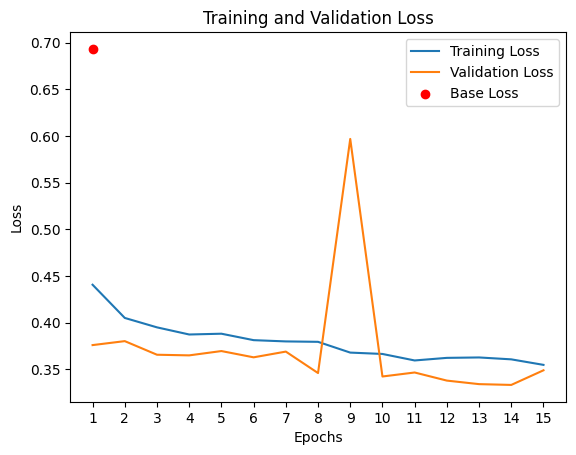

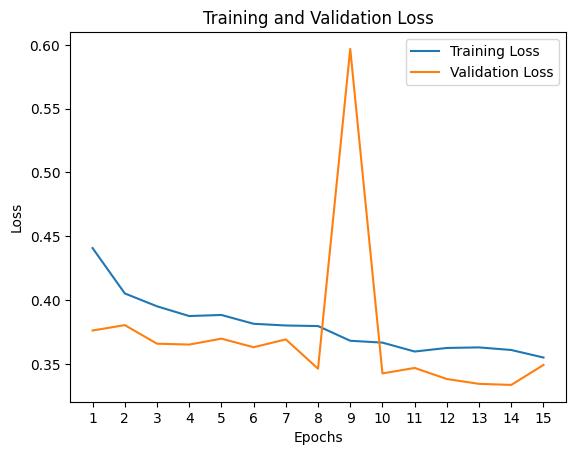

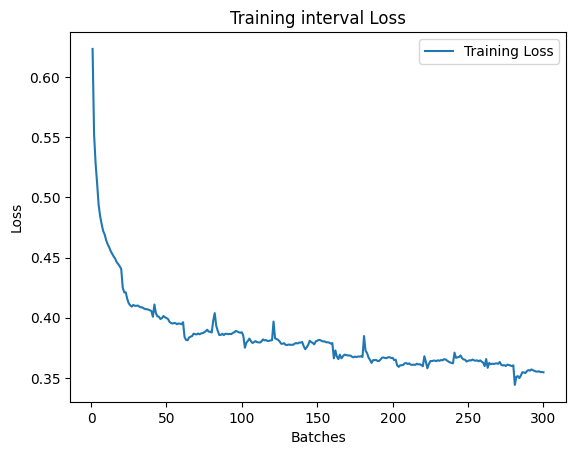

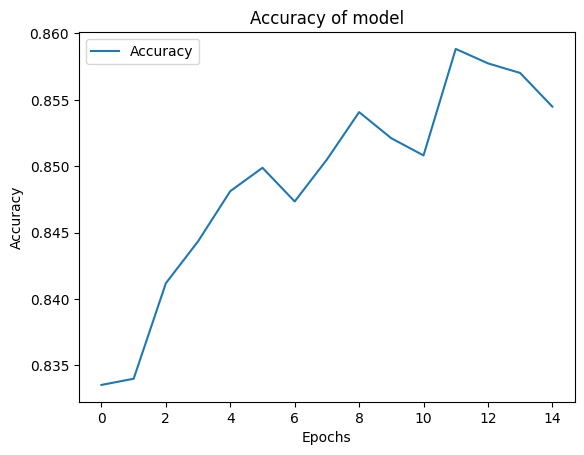

ValueError: Shape of passed values is (149, 149), indices imply (2, 2)

In [215]:
%%time

def plot_data(train_loss, test_loss, base_loss=None):
    '''
    Plot train and test loss
        loss without training
    base_loss

    '''
    num_epoch = [i for i in range(1,len(train_loss)+1)]
    plt.plot(num_epoch, train_loss, label='Training Loss')
    plt.plot(num_epoch, test_loss, label='Validation Loss')
    if base_loss != None:
        plt.scatter(1, base_loss, color='red', label='Base Loss')
    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Set the tick locations
    plt.xticks(arange(1, len(train_loss)+1))
    
    # Display the plot
    plt.legend(loc='best')
    plt.show()



def plot_interval_loss(interval_loss):
    #flatten interval loss
    interval_loss=[element for sublist in interval_loss for element in sublist]
    num_intervals = [i for i in range(1,len(interval_loss)+1)]
    plt.plot(num_intervals, interval_loss, label='Training Loss')
    plt.title('Training interval Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

def plot_accuracy(acc_tab):
    length = [i for i in range(len(acc_tab))]
    plt.plot(length, acc_tab, label='Accuracy')
    plt.title('Accuracy of model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show() 

def print_best(train_loss, test_loss, acc_tab):
    '''
    Dodac dla ktorej epoki najlepsze wyniki dla ktorego
    '''
    print(f"LOWEST TRAIN_LOSS: {min(train_loss)}")
    print(f"LOWEST TEST_LOSS: {min(test_loss)}")
    print(f"HIGHREST ACCURACY: {max(acc_tab)}")

print_best(train_losses, test_losses, accuracies)
plot_data(train_losses, test_losses, base_loss)
plot_data(train_losses, test_losses)
plot_interval_loss(all_interval_losses)
plot_accuracy(accuracies)
#plot_confusion_matrix(test_dl, model_classification)


# EDA OF OUTPUT

1. Take 300 images from dataset
2. Make predictions for all possible angles (0-359)

#### It makes 360*300 = 108k of samples for analysis

3. Save data to pandas df and file
4. Eda of output

# Assumption to test:
#    Angles wich are relatively close to not rotated image as 0,1,2,3,389,358,357 will have a lot more errors than any other

In [25]:
# Load model 
model = torch.load('best_model.pth')
model.eval()  
model

C:\Users\Komfig\AppData\Local\Temp\ipykernel_680\3207204195.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model.pth')


EfficientNet(
  (feature_extractor): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
         

In [68]:
# Take 100 images from dataset - Make changes of Dataset 

class RotNetBinaryDataGeneratorEDA(RotnetBinaryDataGenerator):
    '''
    Generate 100 images with every possible angle (0-359 degrees) and label.
    '''
    def __init__(self, df_cleaned):
        # Inicjalizujemy klasę bazową i bierzemy tylko pierwsze 100 zdjęć
        super().__init__(df_cleaned[:300])
        self.total_angles = 360  # Liczba możliwych rotacji (0-359 stopni)

    def __len__(self):
        # Mnożymy ilość obrazów przez ilość kątów, aby otrzymać pełną długość zbioru danych
        return len(self.df) * self.total_angles

    def __getitem__(self, idx):
        """
        Returns a tuple of (image tensor, label, angle).
        The label is 0 if the image is not rotated, and 1 if it is rotated.
        """
        # Obliczamy właściwy indeks obrazu oraz kąt
        image_idx = idx // self.total_angles
        angle = idx % self.total_angles
        
        image_path = self.df.loc[image_idx, 'filename']
        label = 1 if angle != 0 else 0  # Ustawiamy etykietę: 0 dla nieobróconych, 1 dla obróconych

        image, _ = self.preprocess_engine._make_image(image_path, self.mask, angle)

        tensor = self.transform(image)
        return tensor, label, angle, df.loc[image_idx, 'filename']


1
80
C:\ImageNet100\train.X1\n01440764\n01440764_10029.JPEG


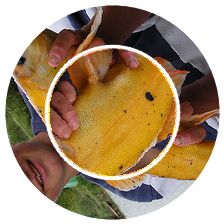

In [69]:
datasetEDA = RotNetBinaryDataGeneratorEDA(df_cleaned)

sample = datasetEDA[800]
image_tensor, label, angle, imagepath = sample
print(sample[1])
print(sample[2])
print(sample[3])
# Konwersja tensora PyTorch na obraz PIL
to_pil = transforms.ToPILImage()
image = to_pil(image_tensor)

# Wyświetlenie obrazu
display(image)
# This image has 2 white spaces on ritght and left, function for preprocessing wokrs good!

In [70]:
EDA_dataloader = DataLoader(datasetEDA, batch_size=360, shuffle=False)

In [71]:
def inference_and_save_results_with_confidence(model, dataloader, output_csv_path="inference_results_with_confidence.csv"):
    """
    Perform inference on a dataset, compute confidence scores, and save the results to a CSV file.

    Args:
        model (torch.nn.Module): The neural network model to use for inference.
        dataloader (torch.utils.data.DataLoader): DataLoader for the data on which to perform inference.
        output_csv_path (str): Path to the output CSV file where results will be saved.

    Returns:
        pd.DataFrame: DataFrame containing the inference results.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for data, label, angle, filename in tqdm(dataloader, desc="Inferencing"):
            data = data.to(device)
            output = model(data)

            # Obliczanie confidence score poprzez zastosowanie softmax na wyjściu modelu
            probabilities = F.softmax(output, dim=1).cpu().numpy()

            # Predykcja klasy
            predicted = probabilities.argmax(axis=1)

            # Przechowywanie wyników
            for i in range(len(predicted)):
                results.append({
                    "filename": filename[i],
                    "true_label": label[i].item(),
                    "predicted_label": predicted[i],
                    "confidence_score": probabilities[i][predicted[i]],  # Pewność modelu co do przewidywania
                    "angle": angle[i].item()
                })

    # Tworzenie DataFrame z wynikami
    results_df = pd.DataFrame(results)

    # Zapisywanie do pliku CSV
    results_df.to_csv(output_csv_path, index=False)

    return results_df

In [72]:
# Zakładam, że model i dataloader są już załadowane oraz skonfigurowane.
model.to(device)
EDA_dataloader = DataLoader(datasetEDA, batch_size=360, shuffle=False)

results_df = inference_and_save_results_with_confidence(model, EDA_dataloader, output_csv_path="inference_results_with_confidence.csv")

Inferencing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:02<00:00,  1.61s/it]


In [75]:
label_map = {
    "n01968897": "chambered nautilus, pearly nautilus, nautilus",
    "n01770081": "harvestman, daddy longlegs, Phalangium opilio",
    "n01818515": "macaw",
    "n02011460": "bittern",
    "n01496331": "electric ray, crampfish, numbfish, torpedo",
    "n01847000": "drake",
    "n01687978": "agama",
    "n01740131": "night snake, Hypsiglena torquata",
    "n01537544": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "n01491361": "tiger shark, Galeocerdo cuvieri",
    "n02007558": "flamingo",
    "n01735189": "garter snake, grass snake",
    "n01630670": "common newt, Triturus vulgaris",
    "n01440764": "tench, Tinca tinca",
    "n01819313": "sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita",
    "n02002556": "white stork, Ciconia ciconia",
    "n01667778": "terrapin",
    "n01755581": "diamondback, diamondback rattlesnake, Crotalus adamanteus",
    "n01924916": "flatworm, platyhelminth",
    "n01751748": "sea snake",
    "n01984695": "spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish",
    "n01729977": "green snake, grass snake",
    "n01614925": "bald eagle, American eagle, Haliaeetus leucocephalus",
    "n01608432": "kite",
    "n01443537": "goldfish, Carassius auratus",
    "n01770393": "scorpion",
    "n01855672": "goose",
    "n01560419": "bulbul",
    "n01592084": "chickadee",
    "n01914609": "sea anemone, anemone",
    "n01582220": "magpie",
    "n01667114": "mud turtle",
    "n01985128": "crayfish, crawfish, crawdad, crawdaddy",
    "n01820546": "lorikeet",
    "n01773797": "garden spider, Aranea diademata",
    "n02006656": "spoonbill",
    "n01986214": "hermit crab",
    "n01484850": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "n01749939": "green mamba",
    "n01828970": "bee eater",
    "n02018795": "bustard",
    "n01695060": "Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis",
    "n01729322": "hognose snake, puff adder, sand viper",
    "n01677366": "common iguana, iguana, Iguana iguana",
    "n01734418": "king snake, kingsnake",
    "n01843383": "toucan",
    "n01806143": "peacock",
    "n01773549": "barn spider, Araneus cavaticus",
    "n01775062": "wolf spider, hunting spider",
    "n01728572": "thunder snake, worm snake, Carphophis amoenus",
    "n01601694": "water ouzel, dipper",
    "n01978287": "Dungeness crab, Cancer magister",
    "n01930112": "nematode, nematode worm, roundworm",
    "n01739381": "vine snake",
    "n01883070": "wombat",
    "n01774384": "black widow, Latrodectus mactans",
    "n02037110": "oystercatcher, oyster catcher",
    "n01795545": "black grouse",
    "n02027492": "red-backed sandpiper, dunlin, Erolia alpina",
    "n01531178": "goldfinch, Carduelis carduelis",
    "n01944390": "snail",
    "n01494475": "hammerhead, hammerhead shark",
    "n01632458": "spotted salamander, Ambystoma maculatum",
    "n01698640": "American alligator, Alligator mississipiensis",
    "n01675722": "banded gecko",
    "n01877812": "wallaby, brush kangaroo",
    "n01622779": "great grey owl, great gray owl, Strix nebulosa",
    "n01910747": "jellyfish",
    "n01860187": "black swan, Cygnus atratus",
    "n01796340": "ptarmigan",
    "n01833805": "hummingbird",
    "n01685808": "whiptail, whiptail lizard",
    "n01756291": "sidewinder, horned rattlesnake, Crotalus cerastes",
    "n01514859": "hen",
    "n01753488": "horned viper, cerastes, sand viper, horned asp, Cerastes cornutus",
    "n02058221": "albatross, mollymawk",
    "n01632777": "axolotl, mud puppy, Ambystoma mexicanum",
    "n01644900": "tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui",
    "n02018207": "American coot, marsh hen, mud hen, water hen, Fulica americana",
    "n01664065": "loggerhead, loggerhead turtle, Caretta caretta",
    "n02028035": "redshank, Tringa totanus",
    "n02012849": "crane",
    "n01776313": "tick",
    "n02077923": "sea lion",
    "n01774750": "tarantula",
    "n01742172": "boa constrictor, Constrictor constrictor",
    "n01943899": "conch",
    "n01798484": "prairie chicken, prairie grouse, prairie fowl",
    "n02051845": "pelican",
    "n01824575": "coucal",
    "n02013706": "limpkin, Aramus pictus",
    "n01955084": "chiton, coat-of-mail shell, sea cradle, polyplacophore",
    "n01773157": "black and gold garden spider, Argiope aurantia",
    "n01665541": "leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea",
    "n01498041": "stingray",
    "n01978455": "rock crab, Cancer irroratus",
    "n01693334": "green lizard, Lacerta viridis",
    "n01950731": "sea slug, nudibranch",
    "n01829413": "hornbill",
    "n01514668": "cock"
}

In [76]:
def get_label_from_filename(filename):
    """
    Extract the label code from the filename and return the corresponding label.
    
    Args:
        filename (str): The filename of the image.
        
    Returns:
        str: The label corresponding to the code in the filename.
    """
    label_code = filename.split('_')[0]  # Zakładam, że kod klasy jest przed pierwszym podkreślnikiem
    return label_map.get(label_code, "Unknown")

# Zakładam, że masz już DataFrame results_df
#results_df['object_label'] = results_df['filename'].apply(get_label_from_filename)

#display(results_df)

In [77]:
display(results_df)

filename  true_label  \
0       C:\ImageNet100\train.X1\n01440764\n01440764_10026.JPEG           0   
1       C:\ImageNet100\train.X1\n01440764\n01440764_10026.JPEG           1   
2       C:\ImageNet100\train.X1\n01440764\n01440764_10026.JPEG           1   
3       C:\ImageNet100\train.X1\n01440764\n01440764_10026.JPEG           1   
4       C:\ImageNet100\train.X1\n01440764\n01440764_10026.JPEG           1   
...                                                        ...         ...   
107995  C:\ImageNet100\train.X1\n01440764\n01440764_13495.JPEG           1   
107996  C:\ImageNet100\train.X1\n01440764\n01440764_13495.JPEG           1   
107997  C:\ImageNet100\train.X1\n01440764\n01440764_13495.JPEG           1   
107998  C:\ImageNet100\train.X1\n01440764\n01440764_13495.JPEG           1   
107999  C:\ImageNet100\train.X1\n01440764\n01440764_13495.JPEG           1   

        predicted_label  confidence_score  angle  
0                     1          0.618028      0  
1                     0          0.896468      1  
2                     0          0.808338      2  
3                     1          0.641941      3  
4                     0          0.925428      4  
...                 ...               ...    ...  
107995                0          0.887002    355  
107996                0          0.853509    356  
107997                0          0.894079    357  
107998                0          0.863011    358  
107999                0          0.895998    359  

[108000 rows x 5 columns]

In [79]:
eda_df = results_df

## EDA of output

Because I need to find limitation and check possible paths of development

1. Accuracy
2. Confusion matrix
3. Distribution of rotation angles for False Negatives
4. Accuracy with tolerance of 5 degrees
5. Confidence score vs predicted label
6. Find best threshold


In [96]:
accuracy = (eda_df['true_label'] == eda_df['predicted_label']).mean()

print(f"Accuracy of model: {accuracy * 100:.2f}%")

Accuracy of model: 84.05%


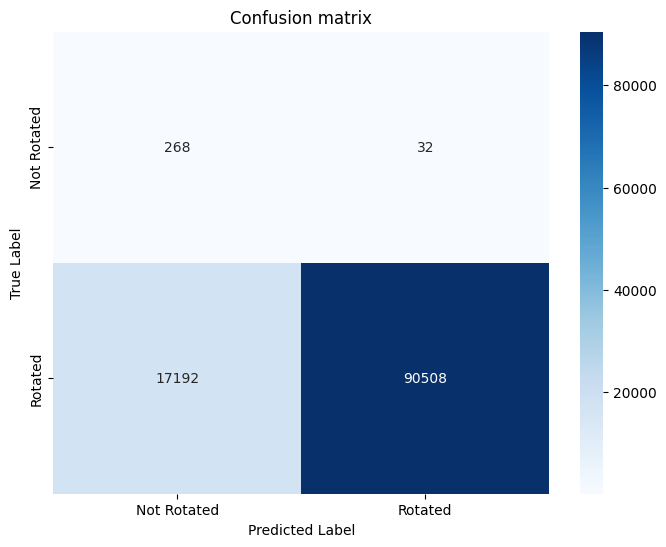

In [97]:
conf_matrix = confusion_matrix(eda_df['true_label'], eda_df['predicted_label'])

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Rotated', 'Rotated'], yticklabels=['Not Rotated', 'Rotated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()

In [98]:
# False Positives: Model przewidział rotację, ale obraz nie był rotowany
false_positives = eda_df[(eda_df['predicted_label'] == 1) & (eda_df['true_label'] == 0)]

# False Negatives: Model nie przewidział rotacji, ale obraz był rotowany
false_negatives = eda_df[(eda_df['predicted_label'] == 0) & (eda_df['true_label'] == 1)]


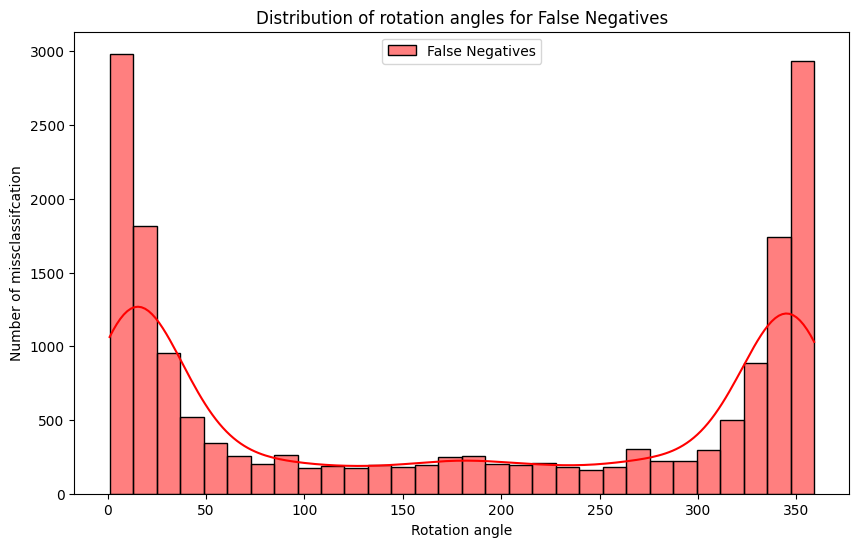

In [100]:
plt.figure(figsize=(10, 6))

# Rozkład kątów dla False Positives
#sns.histplot(false_positives['angle'], kde=True, color='blue', label='False Positives', bins=30)

# Rozkład kątów dla False Negatives
sns.histplot(false_negatives['angle'], kde=True, color='red', label='False Negatives', bins=30)

plt.xlabel('Rotation angle')
plt.ylabel('Number of missclassifcation')
plt.title('Distribution of rotation angles for False Negatives')
plt.legend()
plt.show()


### As predicted angles closer to 0 are those which are mostly misslabeled. Captcha allows to little distortion so let's assumpt We can have error by 5

In [106]:
def is_within_tolerance(true_label, predicted_label, angle):
    if true_label == predicted_label:
        return True
    if true_label == 1 and predicted_label == 0:
        # Jeśli przewidziana rotacja to brak rotacji, ale kąt jest mały
        return angle in [1, 2, 3, 4, 5, 355, 356, 357, 358, 359]
    return False

# Zastosowanie tej funkcji do każdej próbki
eda_df['correct_with_tolerance'] = eda_df.apply(
    lambda row: is_within_tolerance(row['true_label'], row['predicted_label'], row['angle']),
    axis=1
)

# Obliczenie nowej dokładności z uwzględnieniem tolerancji
accuracy_with_tolerance = eda_df['correct_with_tolerance'].mean()
print(f"Średnia dokładność modelu (z tolerancją): {accuracy_with_tolerance * 100:.2f}%")

Średnia dokładność modelu (z tolerancją): 86.52%


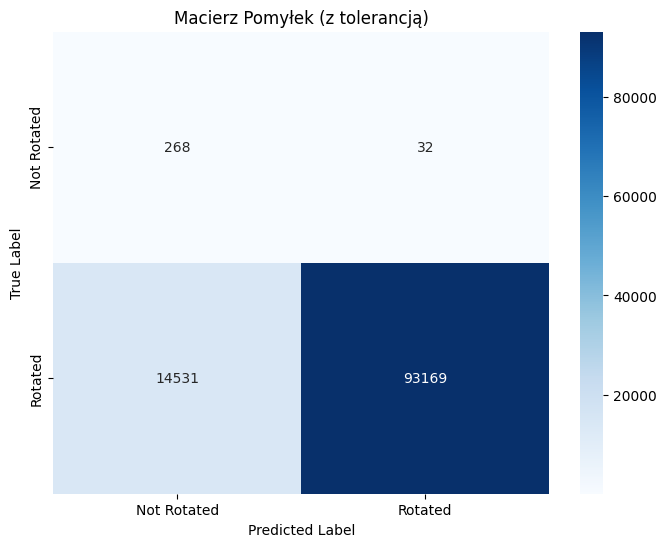

In [107]:
# Obliczenie macierzy pomyłek z tolerancją
conf_matrix_with_tolerance = confusion_matrix(
    eda_df['true_label'],
    eda_df.apply(lambda row: row['predicted_label'] if not row['correct_with_tolerance'] else row['true_label'], axis=1)
)

# Wizualizacja macierzy pomyłek z tolerancją
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_with_tolerance, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Rotated', 'Rotated'], yticklabels=['Not Rotated', 'Rotated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Macierz Pomyłek (z tolerancją)')
plt.show()

In [148]:
# False Positives: Model przewidział rotację, ale obraz nie był rotowany, poza zakresem tolerancji
false_positives_with_tolerance = eda_df[
    (eda_df['predicted_label'] == 1) & 
    (eda_df['true_label'] == 0) & 
    (~eda_df['correct_with_tolerance'])
]

# False Negatives: Model nie przewidział rotacji, ale obraz był rotowany, poza zakresem tolerancji
false_negatives_with_tolerance = eda_df[
    (eda_df['predicted_label'] == 0) & 
    (eda_df['true_label'] == 1) & 
    (~eda_df['correct_with_tolerance'])
]

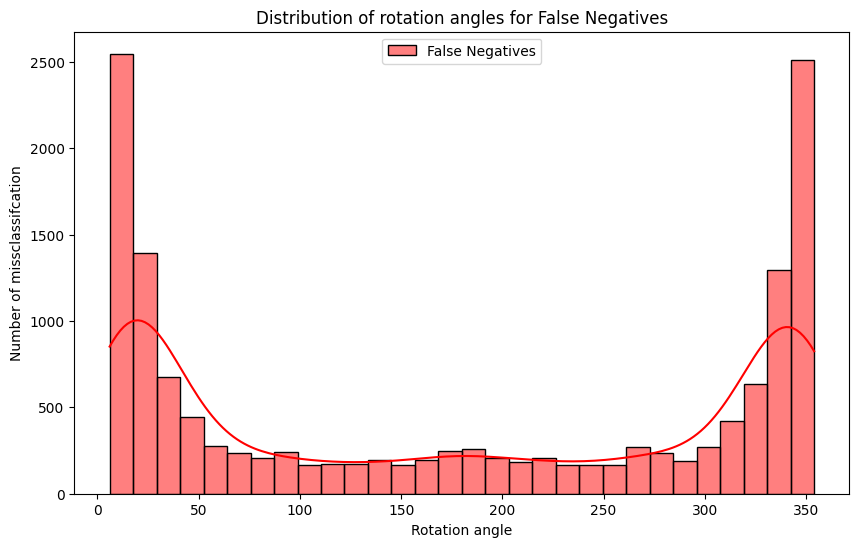

In [149]:
plt.figure(figsize=(10, 6))

# Rozkład kątów dla False Negatives z tolerancją
sns.histplot(false_negatives_with_tolerance['angle'], kde=True, color='red', label='False Negatives', bins=30)

plt.xlabel('Rotation angle')
plt.ylabel('Number of missclassifcation')
plt.title('Distribution of rotation angles for False Negatives')
plt.legend()
plt.show()

In [112]:
# Dodanie kolumny, która wskaże, czy klasyfikacja była poprawna
eda_df['correct'] = eda_df['true_label'] == eda_df['predicted_label']


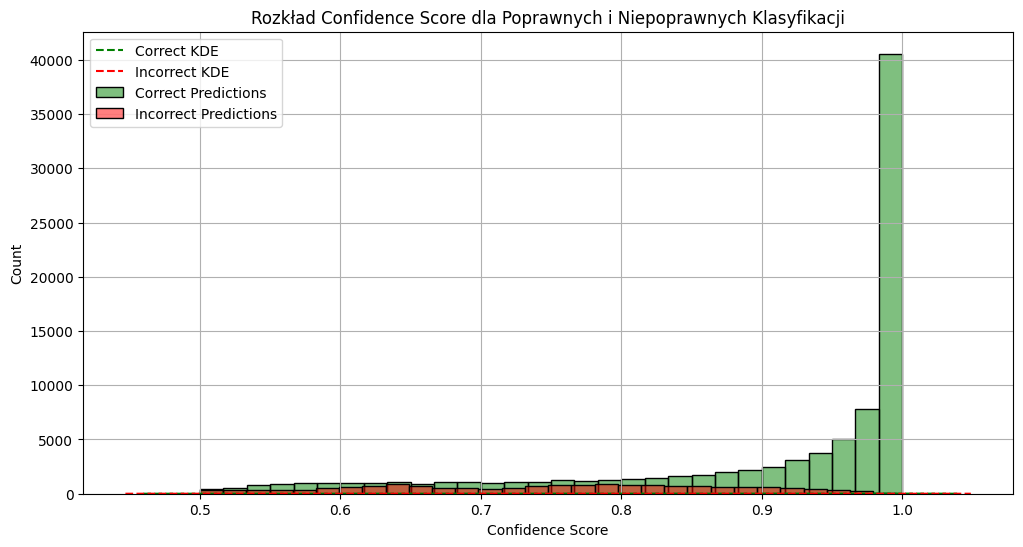

In [116]:
plt.figure(figsize=(12, 6))

# Rozkład dla poprawnych klasyfikacji
sns.histplot(eda_df[eda_df['correct']]['confidence_score'], kde=False, color='green', label='Correct Predictions', alpha=0.5, bins=30)

# Rozkład dla niepoprawnych klasyfikacji
sns.histplot(eda_df[~eda_df['correct']]['confidence_score'], kde=False, color='red', label='Incorrect Predictions', alpha=0.5, bins=30)

# Dodatkowo wykresy KDE
sns.kdeplot(eda_df[eda_df['correct']]['confidence_score'], color='green', label='Correct KDE', linestyle="--")
sns.kdeplot(eda_df[~eda_df['correct']]['confidence_score'], color='red', label='Incorrect KDE', linestyle="--")

plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Rozkład Confidence Score dla Poprawnych i Niepoprawnych Klasyfikacji')
plt.legend()
plt.grid(True)
plt.show()


In [123]:
# Obliczenie dokładności dla grup kątów co 10 stopni
accuracy_vs_angle = eda_df.groupby('angle').apply(
    lambda df: (df['true_label'] == df['predicted_label']).mean()
).reset_index(name='accuracy')

# Grupa według kąta rotacji co 10 stopni i obliczenie średniej pewności oraz dokładności
confidence_vs_angle = eda_df.groupby('angle')['confidence_score'].mean().reset_index()
confidence_vs_angle = confidence_vs_angle.merge(accuracy_vs_angle, on='angle')


C:\Users\Komfig\AppData\Local\Temp\ipykernel_680\1590750246.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_vs_angle = eda_df.groupby('angle').apply(


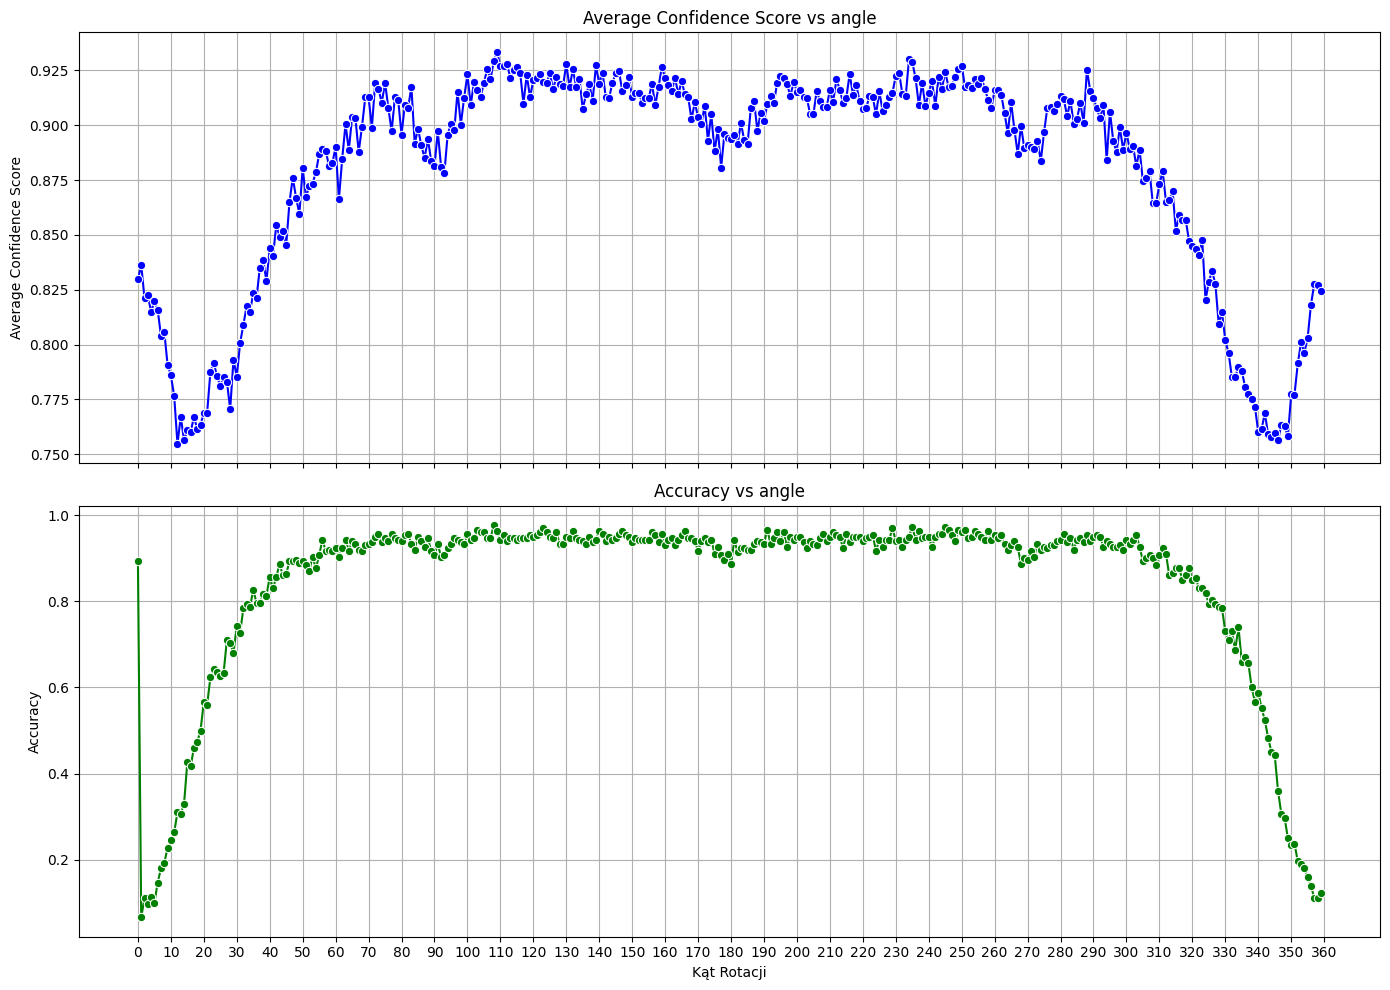

In [181]:
# Ulepszona wizualizacja z dwoma osobnymi wykresami

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Pierwszy wykres: Confidence Score
sns.lineplot(data=confidence_vs_angle, x='angle', y='confidence_score', marker='o', color='blue', ax=ax1)
ax1.set_ylabel('Average Confidence Score')
ax1.set_title('Average Confidence Score vs angle')
ax1.grid(True)

# Drugi wykres: Accuracy
sns.lineplot(data=confidence_vs_angle, x='angle', y='accuracy', marker='o', color='green', ax=ax2)
ax2.set_xlabel('Kąt Rotacji')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs angle')
ax2.grid(True)

# Dostosowanie skali na osi X
plt.xticks(ticks=np.arange(0, 361, 10))  # Wyświetlanie co 10 stopni

plt.tight_layout()
plt.show()


In [126]:
# Obliczenie dokładności dla każdego kąta rotacji
accuracy_vs_angle = eda_df.groupby('angle').apply(
    lambda df: (df['true_label'] == df['predicted_label']).mean()
).reset_index(name='accuracy')


C:\Users\Komfig\AppData\Local\Temp\ipykernel_680\3562346841.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_vs_angle = eda_df.groupby('angle').apply(


In [130]:
# False Positives: Przypadki, gdzie model przewidział rotację, ale obraz nie był rotowany
false_positives = eda_df[(eda_df['predicted_label'] == 1) & (eda_df['true_label'] == 0)]

# False Negatives: Przypadki, gdzie model nie przewidział rotacji, ale obraz był rotowany
false_negatives = eda_df[(eda_df['predicted_label'] == 0) & (eda_df['true_label'] == 1)]

# Liczba FP i FN w zależności od kąta
fp_vs_angle = false_positives.groupby('angle').size().reset_index(name='false_positives')
fn_vs_angle = false_negatives.groupby('angle').size().reset_index(name='false_negatives')


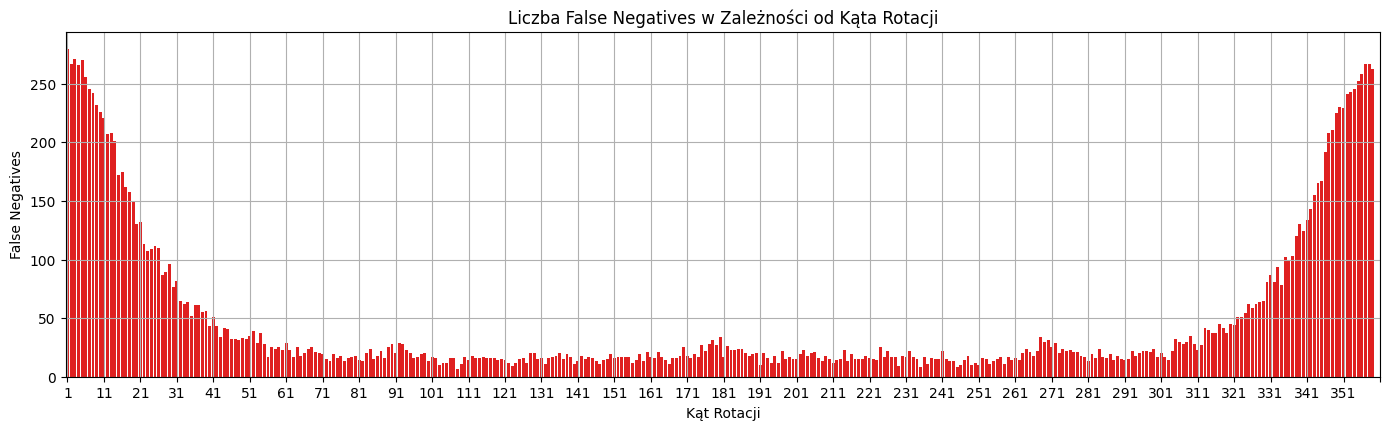

In [133]:
plt.figure(figsize=(14, 8))

# Wykres False Negatives w zależności od kąta rotacji
plt.subplot(2, 1, 2)
sns.barplot(x='angle', y='false_negatives', data=fn_vs_angle, color='red')
plt.xticks(ticks=np.arange(0, 361, 10))  # Wyświetlanie co 30 stopni
plt.xlabel('Kąt Rotacji')
plt.ylabel('False Negatives')
plt.title('Liczba False Negatives w Zależności od Kąta Rotacji')
plt.grid(True)

plt.tight_layout()
plt.show()


In [136]:
low_confidence_threshold = 0.1
high_confidence_threshold = 0.9

# Prawidłowe klasyfikacje z bardzo niskim confidence score
low_confidence_correct = eda_df[(eda_df['correct']) & (eda_df['confidence_score'] < low_confidence_threshold)]

# Niepoprawne klasyfikacje z bardzo wysokim confidence score
high_confidence_incorrect = eda_df[(~eda_df['correct']) & (eda_df['confidence_score'] > high_confidence_threshold)]


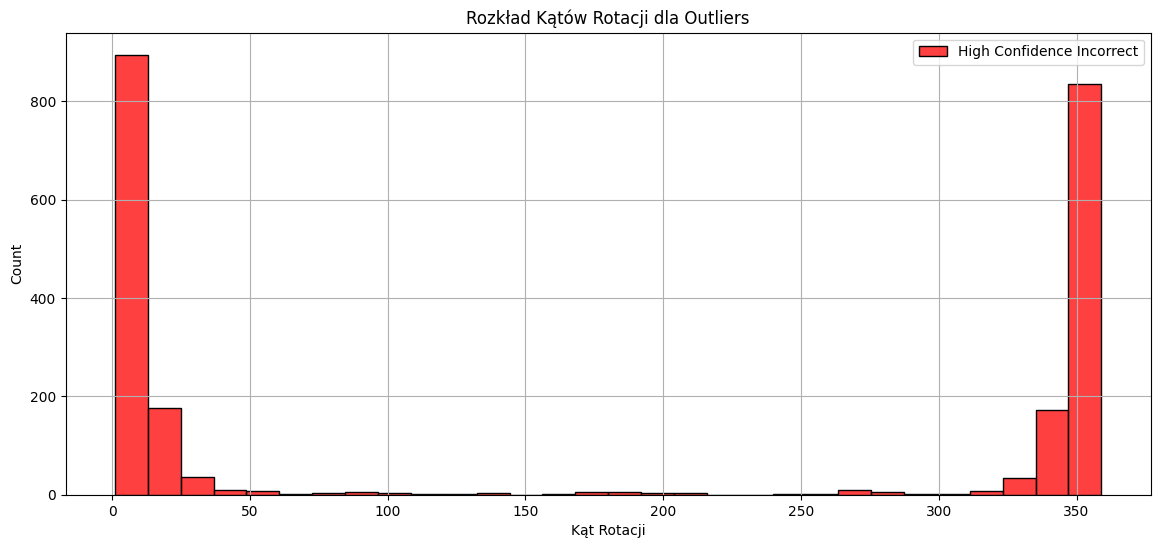

In [137]:
plt.figure(figsize=(14, 6))

# Rozkład kątów rotacji dla niskich confidence score i poprawnych klasyfikacji
sns.histplot(low_confidence_correct['angle'], kde=False, color='blue', label='Low Confidence Correct', bins=30)

# Rozkład kątów rotacji dla wysokich confidence score i błędnych klasyfikacji
sns.histplot(high_confidence_incorrect['angle'], kde=False, color='red', label='High Confidence Incorrect', bins=30)

plt.xlabel('Kąt Rotacji')
plt.ylabel('Count')
plt.title('Rozkład Kątów Rotacji dla Outliers')
plt.legend()
plt.grid(True)
plt.show()


In [139]:


def calculate_metrics_for_threshold(df, threshold):
    df['predicted_label_threshold'] = (df['confidence_score'] >= threshold).astype(int)
    accuracy = accuracy_score(df['true_label'], df['predicted_label_threshold'])
    precision = precision_score(df['true_label'], df['predicted_label_threshold'])
    recall = recall_score(df['true_label'], df['predicted_label_threshold'])
    return accuracy, precision, recall

# Testowanie różnych progów confidence score
thresholds = np.arange(0.0, 1.1, 0.1)
metrics = [calculate_metrics_for_threshold(eda_df.copy(), t) for t in thresholds]

# Konwersja wyników do DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Precision', 'Recall'])
metrics_df['Threshold'] = thresholds


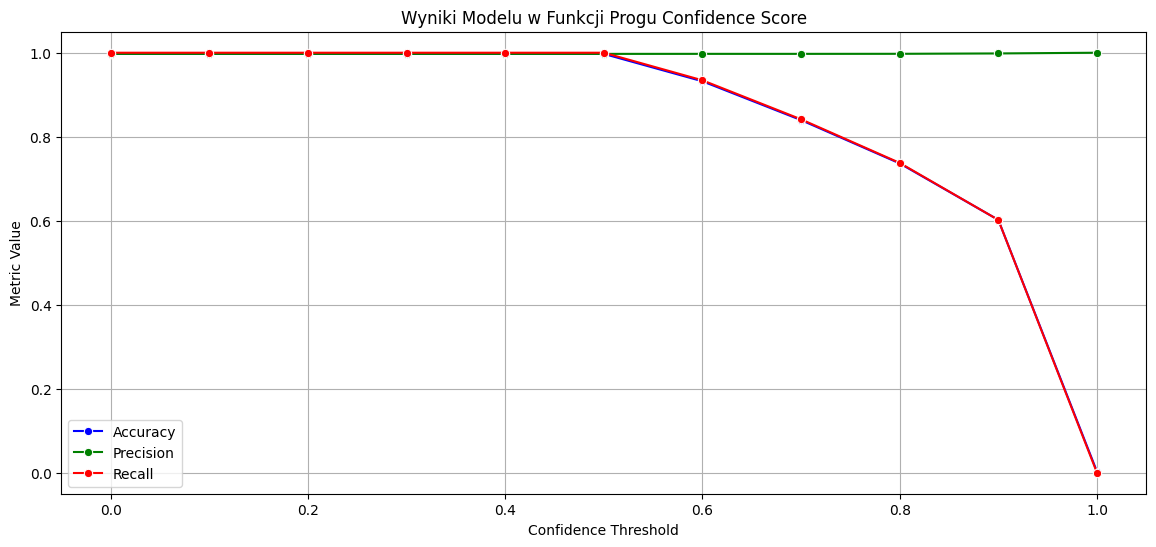

In [140]:
plt.figure(figsize=(14, 6))

# Wykresy dla każdej metryki w funkcji progu
sns.lineplot(data=metrics_df, x='Threshold', y='Accuracy', label='Accuracy', marker='o', color='blue')
sns.lineplot(data=metrics_df, x='Threshold', y='Precision', label='Precision', marker='o', color='green')
sns.lineplot(data=metrics_df, x='Threshold', y='Recall', label='Recall', marker='o', color='red')

plt.xlabel('Confidence Threshold')
plt.ylabel('Metric Value')
plt.title('Wyniki Modelu w Funkcji Progu Confidence Score')
plt.grid(True)
plt.legend()
plt.show()


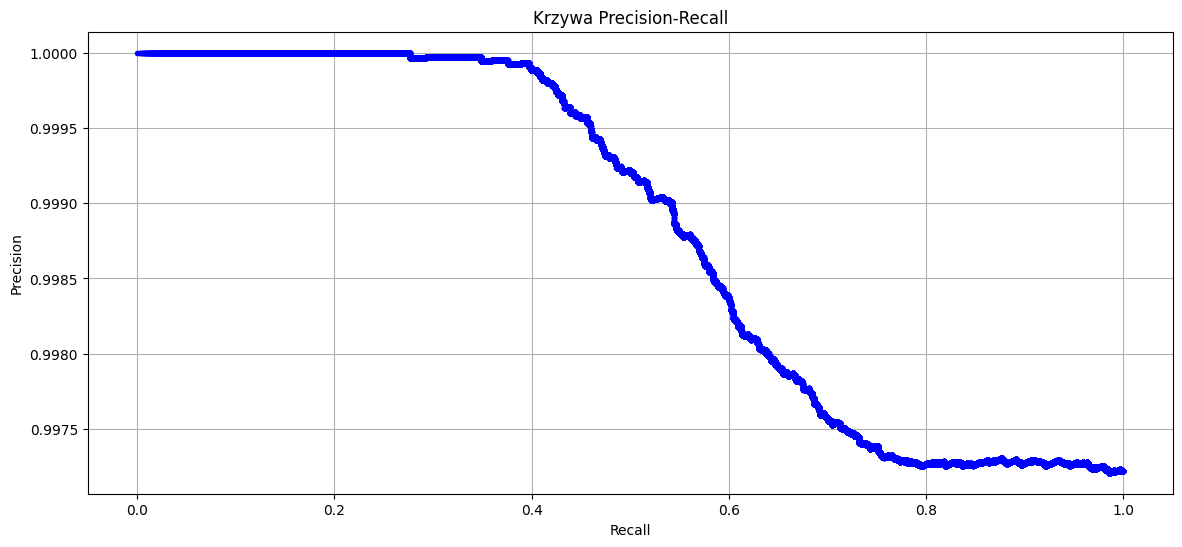

In [141]:
from sklearn.metrics import precision_recall_curve

# Obliczanie krzywej Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(eda_df['true_label'], eda_df['confidence_score'])

# Dodanie wartości progu do precision i recall
thresholds_pr = np.append(thresholds_pr, 1.0)  # Dodanie 1.0 dla porównania
plt.figure(figsize=(14, 6))

# Wykres Precision-Recall
plt.plot(recall, precision, marker='.', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Krzywa Precision-Recall')
plt.grid(True)
plt.show()


# We want to minimize false negative so


In [142]:
# False Negatives: Prawdziwa etykieta to 1 (zrotowane), ale przewidywana etykieta to 0 (niezrotowane)
false_negatives = eda_df[(eda_df['true_label'] == 1) & (eda_df['predicted_label'] == 0)]

# Liczba False Negatives
fn_count = len(false_negatives)
print(f"Liczba False Negatives: {fn_count}")


Liczba False Negatives: 17192


In [143]:
def calculate_false_negatives_for_threshold(df, threshold):
    df['predicted_label_threshold'] = (df['confidence_score'] >= threshold).astype(int)
    false_negatives = df[(df['true_label'] == 1) & (df['predicted_label_threshold'] == 0)]
    return len(false_negatives)

# Testowanie różnych progów confidence score
thresholds = np.arange(0.0, 1.1, 0.1)
false_negatives_count = [calculate_false_negatives_for_threshold(eda_df.copy(), t) for t in thresholds]

# Konwersja wyników do DataFrame
fn_df = pd.DataFrame({'Threshold': thresholds, 'False Negatives': false_negatives_count})


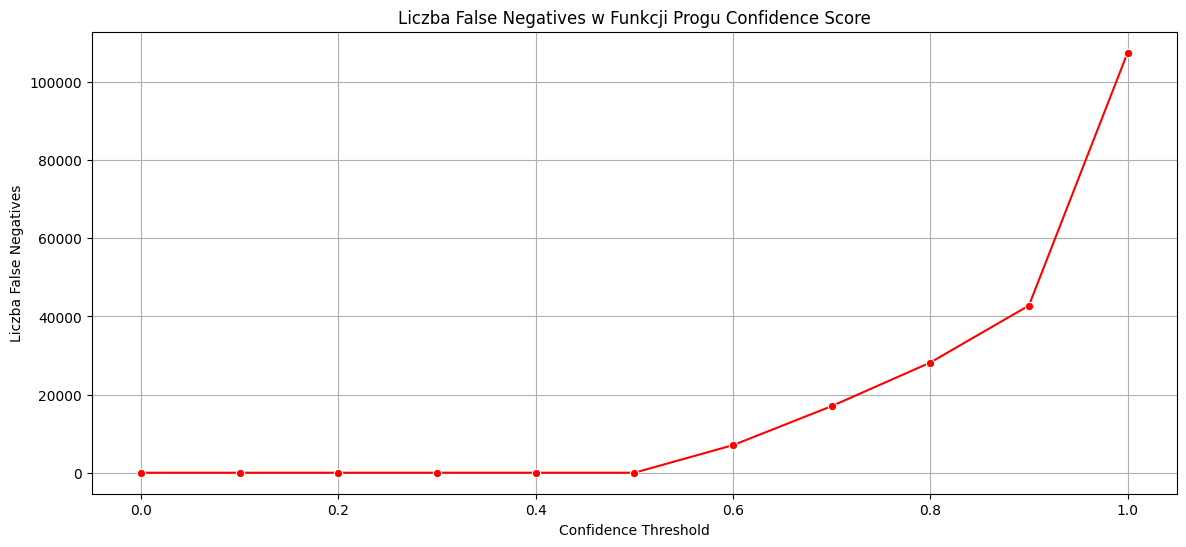

In [144]:
plt.figure(figsize=(14, 6))

sns.lineplot(data=fn_df, x='Threshold', y='False Negatives', marker='o', color='red')
plt.xlabel('Confidence Threshold')
plt.ylabel('Liczba False Negatives')
plt.title('Liczba False Negatives w Funkcji Progu Confidence Score')
plt.grid(True)
plt.show()


In [145]:


# Obliczenie krzywej ROC
fpr, tpr, thresholds = roc_curve(eda_df['true_label'], eda_df['confidence_score'])

# Obliczenie wskaźnika Youdena
youden_index = tpr - fpr
optimal_threshold_index = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_threshold_index]

print(f"Optymalny próg (wg wskaźnika Youdena): {optimal_threshold:.2f}")


Optymalny próg (wg wskaźnika Youdena): 0.97


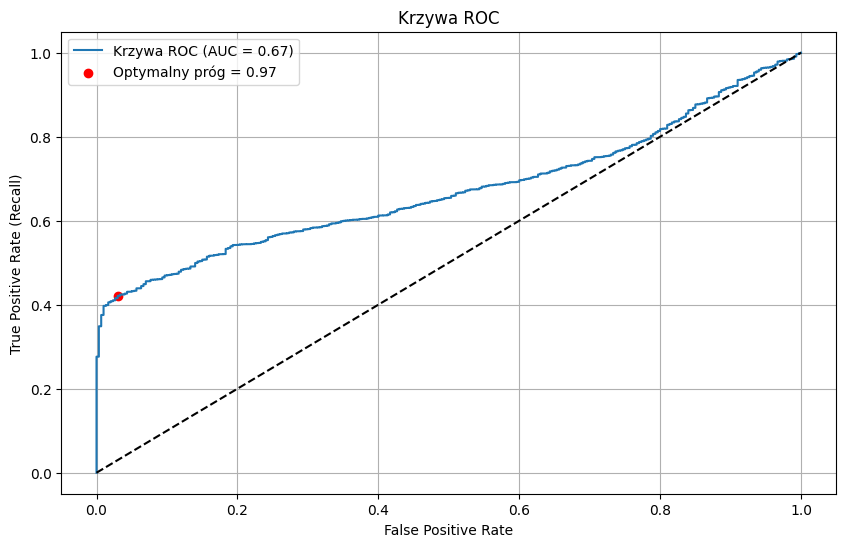

In [146]:
plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, label=f'Krzywa ROC (AUC = {np.trapz(tpr, fpr):.2f})')
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], marker='o', color='red', label=f'Optymalny próg = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Linię referencyjną
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Krzywa ROC')
plt.legend()
plt.grid(True)
plt.show()
